Kristen Swerzenski

DSC 680 Applied Data Science

2 March 2025

# Modeling Environmental Influences on Sea Turtle Nesting Activity

## Introduction

In 2023, sea turtles along Florida’s coastlines nested at unprecedented rates, with loggerhead sea turtles surpassing their previous record by over 30,000 nests and green sea turtles by over 20,000 nests (Kruger, 2023). Being that almost every mile of Florida’s coastline is surveyed by scientists and volunteers to document all sea turtle nesting activity and collect valuable data on the nesting population of these endangered and threatened species, this led to extremely long days of fieldwork in borderline dangerous environments and increased strain on the resources of conservation organizations across the state. As the numbers continued to tick up and the field days became longer, everyone across the state had just one question: could we have seen this coming?

Currently, sea turtle conservation programs rely on retrospective data collection rather than predictive insights. Survey teams hit the beaches at sunrise to document every nest and false crawl, recording data that is essential for long-term monitoring but does little to prepare conservationists for the season ahead. If patterns in nesting activity could be anticipated in advance, conservation organizations could allocate resources more efficiently, ensuring proper coverage of critical nesting areas while reducing the burden on survey teams. Additionally, understanding the factors that drive fluctuations in nesting activity is key to improving long-term conservation strategies. While researchers have long speculated that environmental conditions such as temperature, tides, and lunar cycles may influence nesting behavior, there has been limited research on predictive modeling in this area. One study used ARIMA models and regression techniques to examine the effect of sea surface temperature (SST) on loggerhead nesting activity in Zakynthos, Greece, finding that incorporating SST data improved forecasting accuracy (Mazaris et al 2004). However, few other studies have attempted to develop comprehensive models that integrate multiple environmental factors to predict nesting activity across different regions.

This project presents a data-driven approach to predicting sea turtle nesting activity in Indian River County, FL, using machine learning and time series modeling. The goal of this project is to explore whether patterns in nesting behavior can be anticipated based on environmental factors such as temperature, tides, and lunar cycles. By integrating historical sea turtle crawl data with meteorological, oceanographic, and astronomical datasets, this analysis seeks to identify key drivers of nesting activity and develop predictive models that could aid conservation efforts.

## Data Preparation

The first step in this project is constructing a comprehensive dataset that combines sea turtle nesting activity with relevant environmental variables. Since no existing database integrates these data sources, information must be gathered from multiple providers, including local conservation records, meteorological archives, oceanographic datasets, and astronomical sources. This process involves retrieving, cleaning, and standardizing data from different formats and structures to create a unified dataset suitable for analysis.

First, I will be importing in sea turtle nesting data from the Indian River County Department of Natural Resources. This will be done in two waves due to differences in dataset structures, the first being 2006-2022 and the second being 2023-2024. For both of these groups, column names and values will be standardized, and the dataframes will be pivoted from containing records on individual sea turtle crawls to containing total counts of nests and false crawls per each species per day. This will allow for easier integration with environmental datasets, which are typically recorded at the daily level. Once standardized, the two groups will be merged into a single dataset covering the full time range from 2006 to 2024.

### Sea Turtle Crawl Data 2006-2022

#### Reading in Sea turtle Crawl Data 2006-2022

In [1]:
import pandas as pd
import glob

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Getting all Excel files from 2006-2022
file_list = glob.glob("* ALL DATA.xlsx")

# Reading each file into a dictionary of data frames
dfs = {}

for file in file_list:
    year = file.split()[0] 
    dfs[year] = pd.read_excel(file, sheet_name="Crawls")

#### Standardizing Column Names and Contents

Because there is some variation in the column names and values for the same variables from year to year, we'll have to first standardize them. To do this, I took the most common column and value names that I needed from looking at the different data sets, ran some checks to identify which datasets deviated from these, and addressed them accordingly.

In [5]:
# Performing string formatting for consistency
for year, df in dfs.items():
    if "Species" in df.columns:
        df["Species"] = df["Species"].astype(str).str.lower()
    if "Crawl Result" in df.columns:
        df["Crawl Result"] = df["Crawl Result"].astype(str).str.lower()

In [6]:
# Checking for specific columns in each data frame
required_columns = {'Date Crawled', 'Crawl Result', 'Species'}

# Identifying data frames that do not contain specified columns
for year, df in dfs.items():
    missing_columns = required_columns - set(df.columns)
    if missing_columns:
        print(f"Year {year} is missing columns: {missing_columns}")

Year 2016 is missing columns: {'Date Crawled', 'Crawl Result'}
Year 2017 is missing columns: {'Date Crawled', 'Crawl Result'}
Year 2018 is missing columns: {'Date Crawled', 'Crawl Result'}
Year 2019 is missing columns: {'Date Crawled', 'Crawl Result'}


In [7]:
# Listing the years that had missing columns from previous check
problem_years = ["2016", "2017", "2018", "2019"]

# Printing column names for each problem dataset to investigate
for year in problem_years:
    print(f"Columns in {year}:")
    print(dfs[year].columns.tolist())
    print("\n")

Columns in 2016:
['Date crawled', 'Time', 'Date closed', 'Zone', 'Latitude', 'Longitude', 'GPS acc (m)', 'Species', 'Crawl result', 'Followed', 'Stake ID', 'EAI nest ID', 'Body pits', 'Egg chambers', 'Tideline', 'Clutch depth (m)', 'Notes', 'Clutch verified', 'Distance to dune (m)', 'Stake height_Initial (m)', 'Stake height_Final (m)', 'Obst', 'Dist', 'Emg', 'Inv', 'NPA Sample', 'Marking Sequence', 'User', '3ft from struct', 'Structure type']


Columns in 2017:
['Date Crawled ', 'Time', 'Date closed', 'Zone', 'Latitude', 'Longitude', 'GPS acc (m)', 'Species', 'Crawl result', 'Followed', 'Stake ID', 'EAI nest ID', 'Body Pits', 'Egg Chambers', 'Above Tideline', 'Clutch depth (m)', 'Notes', 'Clutch verified', 'Distance to dune (m)', 'Stake height_initial (m)', 'Stake height_Final (m)', 'Obst', 'Dist', 'Emg', 'Inv', 'NPA Sample', 'Marking Sequence', 'User', '3ft from struct', 'Structure type']


Columns in 2018:
['Date crawled', 'Time', 'Date closed', 'Zone', 'Latitude', 'Longitude', 'GPS 

In [8]:
# Re-mappting problem columns to a standardized name
column_rename_map = {
    "Date Crawled ": "Date Crawled",
    "Date crawled": "Date Crawled",
    "Date closed": "Date Closed",
    "Species": "Species",
    "Crawl result": "Crawl Result",
}

In [9]:
# Applying the mapping
for year, df in dfs.items():
    df.rename(columns=column_rename_map, inplace=True)
    df.columns = df.columns.str.strip()

In [10]:
# Mapping correct column values to standardize values across datasets
species_map = {
    "cc": "loggerhead", "cm": "green", "dc": "leatherback",
    "green_": "green", "loggerhead_": "loggerhead", "leatherback_": "leatherback"
}

crawl_result_map = {
    "false crawl": "fc", "nesting crawl": "nest", "nest": "nest"
}

# Applying mappings
for df in dfs.values():
    df["Species"] = df["Species"].str.lower().replace(species_map, regex=True)
    df["Crawl Result"] = df["Crawl Result"].str.lower().replace(crawl_result_map, regex=True)

In [11]:
# Performing string formatting for consitency
for df in dfs.values():
    df["Species"] = df["Species"].str.strip().str.lower().replace(species_map, regex=True)
    df["Crawl Result"] = df["Crawl Result"].str.strip().str.lower().replace(crawl_result_map, regex=True)

In [12]:
# Printing the unique species and crawl results values to check for inconsistencies
for year, df in dfs.items():
    print(f"Year {year} - Unique Species:", df["Species"].unique())
    print(f"Year {year} - Unique Crawl Results:", df["Crawl Result"].unique())

Year 2006 - Unique Species: ['loggerhead' 'green']
Year 2006 - Unique Crawl Results: ['nest' 'fc']
Year 2007 - Unique Species: ['green' 'loggerhead' 'leatherback' 'nan']
Year 2007 - Unique Crawl Results: ['nest' 'fc' 'nan']
Year 2008 - Unique Species: ['loggerhead' 'green' 'leatherback' 'nan']
Year 2008 - Unique Crawl Results: ['fc' 'nest' 'nan']
Year 2009 - Unique Species: ['loggerhead' 'green' 'leatherback']
Year 2009 - Unique Crawl Results: ['nest' 'fc']
Year 2010 - Unique Species: ['leatherback' 'loggerhead' 'green']
Year 2010 - Unique Crawl Results: ['nest' 'fc']
Year 2011 - Unique Species: ['leatherback' 'loggerhead' 'green']
Year 2011 - Unique Crawl Results: ['nest' 'fc']
Year 2012 - Unique Species: ['loggerhead' 'nan' 'green' 'leatherback']
Year 2012 - Unique Crawl Results: ['nest' 'fc']
Year 2013 - Unique Species: ['green' 'loggerhead' 'leatherback']
Year 2013 - Unique Crawl Results: ['nest' 'fc']
Year 2014 - Unique Species: ['loggerhead' 'green' 'leatherback']
Year 2014 - Uni

#### Pivoting the Data

The next step will be pivoting these datasets to give us crawl counts by date. In other words, for each single day, I just want a count of how many nesting and non-nesting sea turtle crawls were documented for each species. Once each data frame is pivoted, we can concatenate them all togther into a single data frame from 2006-2022.

In [13]:
pivoted_dfs = []

for year, df in dfs.items():
    # Grouping and count occurrences of each by date
    df_counts = df.groupby(['Date Crawled', 'Crawl Result', 'Species']).size().reset_index(name='count')
    
    # Pivoting the table on Date Crawled
    pivot_df = df_counts.pivot_table(index='Date Crawled', 
                                     columns=['Species', 'Crawl Result'], 
                                     values='count', 
                                     aggfunc='sum', 
                                     fill_value=0)

    # Flattening the multi-level columns
    pivot_df.columns = [f'{species}_{crawl_type}' for species, crawl_type in pivot_df.columns]

    # Resetting index to bring 'Date Crawled' back as a column
    pivot_df.reset_index(inplace=True)

    # Storing dfs in list
    pivoted_dfs.append(pivot_df)

# Concatenating all pivoted data frames into a single dataframe
final_df = pd.concat(pivoted_dfs, ignore_index=True)

final_df.head(20)

,Date Crawled,green_fc,green_nest,loggerhead_fc,loggerhead_nest,leatherback_nest,leatherback_fc,other_fc
0,2006-05-08 00:00:00,0,0,2,0,NaN,NaN,NaN
1,2006-05-10 00:00:00,0,0,1,1,NaN,NaN,NaN
2,2006-05-11 00:00:00,0,0,1,0,NaN,NaN,NaN
3,2006-05-13 00:00:00,1,0,2,0,NaN,NaN,NaN
4,2006-05-14 00:00:00,0,0,5,0,NaN,NaN,NaN
5,2006-05-15 00:00:00,0,0,1,0,NaN,NaN,NaN
6,2006-05-16 00:00:00,0,0,5,1,NaN,NaN,NaN
7,2006-05-17 00:00:00,0,0,3,1,NaN,NaN,NaN
8,2006-05-18 00:00:00,0,0,1,1,NaN,NaN,NaN
9,2006-05-20 00:00:00,0,0,2,1,NaN,NaN,NaN


#### Cleaning Up the Data

Not that the data is all together, I can clean it up a little. First, I am going to drop that "other_fc" column because that just indicates the species was unknown, which isn't much help and doesn't give us a lot of information anyway. Next, all NaN values will be filled with 0s because they should represent that no crawls of that kind were documented that day, and keeping them as NaNs is ambiguous. LAst, I am going to convert all numerical data types to whole integers for easier handling.

In [14]:
# Removing the "other" column 
if 'other_fc' in final_df.columns:
    final_df.drop(columns=['other_fc'], inplace=True)

# Filling NaN values with 0
final_df.fillna(0, inplace=True)

# Converting all numerical columns to integers
for col in final_df.columns:
    if col != 'Date Crawled':
        final_df[col] = final_df[col].astype(int)
        
final_df.head()

,Date Crawled,green_fc,green_nest,loggerhead_fc,loggerhead_nest,leatherback_nest,leatherback_fc
0,2006-05-08 00:00:00,0,0,2,0,0,0
1,2006-05-10 00:00:00,0,0,1,1,0,0
2,2006-05-11 00:00:00,0,0,1,0,0,0
3,2006-05-13 00:00:00,1,0,2,0,0,0
4,2006-05-14 00:00:00,0,0,5,0,0,0


### Sea Turtle Crawl Data 2023 and 2024

Next, I am going to tackle the 2023-2024 data. Due to changes in ddata collection methods, these two years more closely resemble each other in structure as opposed to the rest of the yearly data sets, so I decided to handle them seperately before bringing them together with the rest of the sea turtle data. A lot of the same steps will be taken with these data sets as with the 2006-2022 ones, including string formatting, aligning the column names and values, and pivoting the table. 

#### Loading in the Data

In [15]:
# Loading data for 2023 and 2024
years_to_load = [2023, 2024]
dfs_new = {}

for year in years_to_load:
    file_name = f"{year} Crawls.xlsx"  
    dfs_new[year] = pd.read_excel(file_name)

#### Cleaning and Standardizing the Data

In [16]:
# Checking the column names to see what needs to be formattedd
for year in dfs_new:
    print(f"Columns in {year}:")
    print(dfs_new[year].columns.tolist())
    print("\n")

Columns in 2023:
['OBJECTID', 'CrawlDate', 'CrawlDateText', 'Time', 'Zone', 'Latitude', 'Longitude', 'CrawlObserverID', 'Species', 'CrawlType', 'Nest_FC', 'NestMarked', 'NestType', 'NestID', 'EAI', 'EAINestID', 'ClutchFound', 'StakeHT_Initial_m', 'StakeHT_Initial_cm', 'ClutchDepth_m', 'DuneDistance_m', 'ABP', 'AEC', 'SeawardofHumanMadeStructure', 'Within3FTofStructure', 'HumanMadeStructureType', 'NumberofObstructions', 'ObstructionType1', 'ObstructionType2', 'ObstructionType3', 'ObstructionType4', 'ScarpHeight_m', 'ObsFC', 'ObstructionLocation', 'CrawlComments', 'OpenClose', 'PointType', 'Year', 'UniqueNestID', 'CommonName', 'CommonNameFWCONA', 'SpeciesCodeFWC', 'NestLabelText', 'NestNumberText', 'TotalNestNumber', 'LoggerMarkingScheme', 'GreenMarkingScheme', 'LeatherMarkingScheme', 'EmergenceRecorded', 'InventoryRecorded', 'NestDestroyed', 'WasPhotographTaken_', 'ObstructionCode1', 'ObstructionCode2', 'ObstructionCode3', 'ObstructionCode4', 'CombinedObstructionsIRC', 'CombinedObsFWCON

In [17]:
# Performing some basic string formatting and column renaming for consistency with other data
for year, df in dfs_new.items():
    df.columns = df.columns.str.strip().str.lower()
    df.rename(columns={"crawldate": "Date Crawled", "nest_fc": "Crawl Result", "species": "Species"}, inplace=True)
    # Ensuring the correct species and crawl result values
    df["Species"] = df["Species"].str.lower().replace(species_map, regex=True)
    df["Crawl Result"] = df["Crawl Result"].str.strip().str.lower().replace(crawl_result_map, regex=True)

In [18]:
# Checking column names for consistency
for year in dfs_new:
    print(f"Columns in {year}:")
    print(dfs_new[year].columns.tolist()
    print("\n")

Columns in 2023:
['objectid', 'Date Crawled', 'crawldatetext', 'time', 'zone', 'latitude', 'longitude', 'crawlobserverid', 'Species', 'crawltype', 'Crawl Result', 'nestmarked', 'nesttype', 'nestid', 'eai', 'eainestid', 'clutchfound', 'stakeht_initial_m', 'stakeht_initial_cm', 'clutchdepth_m', 'dunedistance_m', 'abp', 'aec', 'seawardofhumanmadestructure', 'within3ftofstructure', 'humanmadestructuretype', 'numberofobstructions', 'obstructiontype1', 'obstructiontype2', 'obstructiontype3', 'obstructiontype4', 'scarpheight_m', 'obsfc', 'obstructionlocation', 'crawlcomments', 'openclose', 'pointtype', 'year', 'uniquenestid', 'commonname', 'commonnamefwcona', 'speciescodefwc', 'nestlabeltext', 'nestnumbertext', 'totalnestnumber', 'loggermarkingscheme', 'greenmarkingscheme', 'leathermarkingscheme', 'emergencerecorded', 'inventoryrecorded', 'nestdestroyed', 'wasphotographtaken_', 'obstructioncode1', 'obstructioncode2', 'obstructioncode3', 'obstructioncode4', 'combinedobstructionsirc', 'combined

In [18]:
# Checking species and crawl result values for consistency
for year, df in dfs_new.items():
    print(f"Year {year} - Unique Species:", df["Species"].unique())
    print(f"Year {year} - Unique Crawl Results:", df["Crawl Result"].unique())

Year 2023 - Unique Species: ['loggerhead' 'leatherback' 'green']
Year 2023 - Unique Crawl Results: ['fc' 'nest']
Year 2024 - Unique Species: ['leatherback' 'loggerhead' 'green']
Year 2024 - Unique Crawl Results: ['n' 'fc']


Looks like 2024 had "n" instead of "nest", so I'll handle that quickly.

In [21]:
# Replacing "n" with "nest"
dfs_new[2024]["Crawl Result"] = dfs_new[2024]["Crawl Result"].replace("n", "nest")

In [22]:
# Rechecking values
for year, df in dfs_new.items():
    print(f"Year {year} - Unique Species:", df["Species"].unique())
    print(f"Year {year} - Unique Crawl Results:", df["Crawl Result"].unique())

Year 2023 - Unique Species: ['loggerhead' 'leatherback' 'green']
Year 2023 - Unique Crawl Results: ['fc' 'nest']
Year 2024 - Unique Species: ['leatherback' 'loggerhead' 'green']
Year 2024 - Unique Crawl Results: ['nest' 'fc']


#### Pivoting the Table 

Like the above data, I am going to pivot and combine the data frames, but this time by creating a function that also combines some of the cleaning and formatting steps.

In [23]:
# Defining a function to pivot the data based on the code used in 2006-2022
def pivot_data(df):
    # Grouping by Date Crawled, Species, and Crawl Result, count occurrences
    df_counts = df.groupby(['Date Crawled', 'Species', 'Crawl Result']).size().reset_index(name='count')

    # Pivoting the grouped data
    pivot_df = df_counts.pivot_table(index='Date Crawled', 
                                     columns=['Species', 'Crawl Result'], 
                                     values='count', 
                                     aggfunc='sum', 
                                     fill_value=0)

    # Flattening multi-index columns
    pivot_df.columns = [f'{species}_{crawl}' for species, crawl in pivot_df.columns]

    # Keeping only the required columns
    expected_columns = ['leatherback_fc', 'leatherback_nest', 
                        'loggerhead_fc', 'loggerhead_nest', 
                        'green_fc', 'green_nest']

    pivot_df = pivot_df[[col for col in expected_columns if col in pivot_df.columns]]

    # Resetting index and return the pivoted dat aframe
    pivot_df.reset_index(inplace=True)
    
    # Dropping 'other_fc' column if it exists, fill NaNs with 0, and converting all numbers to floats
    if 'other_fc' in pivot_df.columns:
        pivot_df.drop(columns=['other_fc'], inplace=True)
    pivot_df.fillna(0, inplace=True)
    
    # Converting numerical columns to float
    for col in pivot_df.columns:
        if col != 'Date Crawled':  # Exclude the date column from conversion
            pivot_df[col] = pivot_df[col].astype(float)

    return pivot_df

# Pivoting the 2023 and 2024 data
pivot_dfs_new = {year: pivot_data(df) for year, df in dfs_new.items()}

#### Combining the Sea Turtle Crawl Data

Last, I am going to combine the 2006-2022 data with the newly formatted 2023-2024 data and clean it up a bit by changing some data types and reformatting the date time column by stripping the time since it is not needed.

In [24]:
# Concatenating 2006-2022 data and 2023-2024 data
pivot_df_all = pd.concat([final_df] + list(pivot_dfs_new.values()), ignore_index=True)

In [25]:
# Checking pivoted crawl data
pivot_df_all.head()

,Date Crawled,green_fc,green_nest,loggerhead_fc,loggerhead_nest,leatherback_nest,leatherback_fc
0,2006-05-08 00:00:00,0.0,0.0,2.0,0.0,0.0,0.0
1,2006-05-10 00:00:00,0.0,0.0,1.0,1.0,0.0,0.0
2,2006-05-11 00:00:00,0.0,0.0,1.0,0.0,0.0,0.0
3,2006-05-13 00:00:00,1.0,0.0,2.0,0.0,0.0,0.0
4,2006-05-14 00:00:00,0.0,0.0,5.0,0.0,0.0,0.0


In [26]:
# Checking the end of the data frame to ensure new values were concatenated
pivot_df_all.tail(10)

,Date Crawled,green_fc,green_nest,loggerhead_fc,loggerhead_nest,leatherback_nest,leatherback_fc
4010,2024-09-12 04:00:00,0.0,1.0,0.0,0.0,0.0,0.0
4011,2024-09-13 04:00:00,3.0,2.0,0.0,0.0,0.0,0.0
4012,2024-09-14 04:00:00,1.0,0.0,0.0,0.0,0.0,0.0
4013,2024-09-16 04:00:00,1.0,0.0,0.0,0.0,0.0,0.0
4014,2024-09-18 04:00:00,1.0,0.0,0.0,0.0,0.0,0.0
4015,2024-09-19 04:00:00,0.0,1.0,0.0,0.0,0.0,0.0
4016,2024-09-21 04:00:00,0.0,1.0,0.0,0.0,0.0,0.0
4017,2024-09-22 04:00:00,1.0,1.0,0.0,0.0,0.0,0.0
4018,2024-09-24 04:00:00,2.0,0.0,0.0,0.0,0.0,0.0
4019,2024-10-05 04:00:00,0.0,1.0,0.0,0.0,0.0,0.0


In [27]:
# Filling NaN values with 0
pivot_df_all.fillna(0, inplace=True)

# Converting all numerical columns to floats
for col in pivot_df_all.columns:
    if col != 'Date Crawled':
        pivot_df_all[col] = pivot_df_all[col].astype(int)

# Checking the data frame
pivot_df_all.tail()

,Date Crawled,green_fc,green_nest,loggerhead_fc,loggerhead_nest,leatherback_nest,leatherback_fc
4015,2024-09-19 04:00:00,0,1,0,0,0,0
4016,2024-09-21 04:00:00,0,1,0,0,0,0
4017,2024-09-22 04:00:00,1,1,0,0,0,0
4018,2024-09-24 04:00:00,2,0,0,0,0,0
4019,2024-10-05 04:00:00,0,1,0,0,0,0


In [28]:
# Stripping the time from the Date Crawled column
pivot_df_all['Date Crawled'] = pd.to_datetime(pivot_df_all['Date Crawled'])
pivot_df_all['Date Crawled'] = pivot_df_all['Date Crawled'].dt.date
pivot_df_all.head()

,Date Crawled,green_fc,green_nest,loggerhead_fc,loggerhead_nest,leatherback_nest,leatherback_fc
0,2006-05-08,0,0,2,0,0,0
1,2006-05-10,0,0,1,1,0,0
2,2006-05-11,0,0,1,0,0,0
3,2006-05-13,1,0,2,0,0,0
4,2006-05-14,0,0,5,0,0,0


Another thing I am going to do is fill in any missing dates. If a date is missing, that just means there weer no sea turtle crawls on that day which is still important information to know, especially around the beginning and the end of the nesting season where crawls may not occur every day. Sea turtle nesting season typically runs from March 1st through October 31st. However, due to changing environmental conditions, this season is expanding - last season the state saw nests laid as late as December, and this current 2025 season we already had our first leatherback nest of the season laid in early February. Because the season is becoming less and less defined, I am choosing to include every day between January 1st 2006 and December 31st 2024 to ensure that we have a continous calendar represented of sea turtle activity so we can analyze all seasonal environmental trends.

In [29]:
# Ensuring Date Crawled is datetime
pivot_df_all['Date Crawled'] = pd.to_datetime(pivot_df_all['Date Crawled'])

# Defining start and end dates
start_date = '2006-01-01'
end_date = '2024-12-31'

# Creating a date range for the full period from Jan 1st to December31st
full_date_range = pd.date_range(start=start_date, end=end_date)

# Converting the full date range to a DataFrame
full_dates_df = pd.DataFrame(full_date_range, columns=['Date Crawled'])

# Merging existing data frame with the full dates data frame
df_final = pd.merge(full_dates_df, pivot_df_all, on='Date Crawled', how='left')

# Filling NaN values with 0s
df_final.fillna(0, inplace=True)

# Checking the data frame
df_final.head()

,Date Crawled,green_fc,green_nest,loggerhead_fc,loggerhead_nest,leatherback_nest,leatherback_fc
0,2006-01-01,0.0,0.0,0.0,0.0,0.0,0.0
1,2006-01-02,0.0,0.0,0.0,0.0,0.0,0.0
2,2006-01-03,0.0,0.0,0.0,0.0,0.0,0.0
3,2006-01-04,0.0,0.0,0.0,0.0,0.0,0.0
4,2006-01-05,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# Converting crawl count variables to integers
for col in df_final.columns:
    if col != 'Date Crawled':
        df_final[col] = df_final[col].astype(int)

df_final.head()

,Date Crawled,green_fc,green_nest,loggerhead_fc,loggerhead_nest,leatherback_nest,leatherback_fc
0,2006-01-01,0,0,0,0,0,0
1,2006-01-02,0,0,0,0,0,0
2,2006-01-03,0,0,0,0,0,0
3,2006-01-04,0,0,0,0,0,0
4,2006-01-05,0,0,0,0,0,0


#### Adding Total Crawl Variables

To make analyzing overall trends in nesting activity easier, I am going to create a number of new variables that contain some daily total crawl variables. Specifically, I am going to include total crawls (nesting and non-nesting) by each species, total non-nesting crawls, total nesting crawls, and total crawls all together.

In [31]:
# Adding total green crawls (fc + nests)
df_final['total_green_crawls'] = df_final['green_fc'] + df_final['green_nest']

# Adding total loggerhead crawls (fc + nests)
df_final['total_loggerhead_crawls'] = df_final['loggerhead_fc'] + df_final['loggerhead_nest']

# Adding total leatherback crawls (fc + nests)
df_final['total_leatherback_crawls'] = df_final['leatherback_fc'] + df_final['leatherback_nest']

# Adding total crawls (all species)
df_final['total_crawls'] = df_final['total_green_crawls'] + df_final['total_loggerhead_crawls'] + df_final['total_leatherback_crawls']

# Adding total false cralws (all species)
df_final['total_false_crawls'] = df_final['green_fc'] + df_final['loggerhead_fc'] + df_final['leatherback_fc']

# Adding total nesting crawls (all species)
df_final['total_nests'] = df_final['green_nest'] + df_final['loggerhead_nest'] + df_final['leatherback_nest']

In [32]:
# Checking data frame with new variables
df_final.head()

,Date Crawled,green_fc,green_nest,loggerhead_fc,loggerhead_nest,leatherback_nest,leatherback_fc,total_green_crawls,total_loggerhead_crawls,total_leatherback_crawls,total_crawls,total_false_crawls,total_nests
0,2006-01-01,0,0,0,0,0,0,0,0,0,0,0,0
1,2006-01-02,0,0,0,0,0,0,0,0,0,0,0,0
2,2006-01-03,0,0,0,0,0,0,0,0,0,0,0,0
3,2006-01-04,0,0,0,0,0,0,0,0,0,0,0,0
4,2006-01-05,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
# Checking a random snippet of the new data frame
df_final.iloc[365:450]

,Date Crawled,green_fc,green_nest,loggerhead_fc,loggerhead_nest,leatherback_nest,leatherback_fc,total_green_crawls,total_loggerhead_crawls,total_leatherback_crawls,total_crawls,total_false_crawls,total_nests
365,2007-01-01,0,0,0,0,0,0,0,0,0,0,0,0
366,2007-01-02,0,0,0,0,0,0,0,0,0,0,0,0
367,2007-01-03,0,0,0,0,0,0,0,0,0,0,0,0
368,2007-01-04,0,0,0,0,0,0,0,0,0,0,0,0
369,2007-01-05,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,2007-03-22,0,0,0,0,0,0,0,0,0,0,0,0
446,2007-03-23,0,0,0,0,0,0,0,0,0,0,0,0
447,2007-03-24,0,0,0,0,0,0,0,0,0,0,0,0
448,2007-03-25,0,0,0,0,0,0,0,0,0,0,0,0


The sea turtle crawl data is now cleaned, formatted, and ready to be integrated with environmental data.

### Weather Data

Now that the sea turtle data is in a good place, we need to work on retrieving the additional variables of interest that we want to incorporate into this data set. In particular, my goal is to include temperature, precipitation, sea surface temperature, moon phase, and tidal information. First, I am going to focus on the meteorological data. To retrieve this data, I am going to use the Python library Meteostat and port in meteorogical data through their API. To do this, I am going to define a latitude and longitude point near where the the sea turtle crawl data was collected so that the weather data could be retrieved from the nearest station. Daily data will be imported so that it can be merged with the daily crawl data by date.

#### Retrieving Weather Data

In [34]:
from datetime import datetime
from meteostat import Point, Daily

In [35]:
# Defining location coordinates near study site
location = Point(27.761868, -80.395942, 0)

# Defining the start and end dates
start = datetime(2006, 1, 1)
end = datetime(2024, 12, 31)

# Fetching daily data
data = Daily(location, start, end)
data = data.fetch()

# Resetting index
data.reset_index(inplace=True)

# Displaying the first few rows
data.head()

,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2006-01-01,19.5,10.9,27.5,0.0,NaN,NaN,8.3,NaN,1018.5,NaN
1,2006-01-02,22.4,17.0,28.6,0.0,NaN,187.0,13.0,NaN,1018.3,NaN
2,2006-01-03,21.6,13.6,28.6,0.0,NaN,257.0,20.5,NaN,1015.9,NaN
3,2006-01-04,16.6,10.9,24.2,0.0,NaN,NaN,7.9,NaN,1017.1,NaN
4,2006-01-05,16.3,9.2,24.7,0.0,NaN,NaN,10.8,NaN,1012.9,NaN


In [36]:
# Renaming the date/time column to match sea turtle data frame
data.rename(columns={'Date Crawled': 'time'}, inplace=True)

#### Merging Weather Data with Sea Turtle Data

In [37]:
# Merging the datasets
merged_df = pd.merge(df_final, data, left_on='Date Crawled', right_on='time', how='left')

# Dropping the 'time' column
merged_df.drop(columns=['time'], inplace=True)

# Checking the merged data set
merged_df.head()

,Date Crawled,green_fc,green_nest,loggerhead_fc,loggerhead_nest,leatherback_nest,leatherback_fc,total_green_crawls,total_loggerhead_crawls,total_leatherback_crawls,total_crawls,total_false_crawls,total_nests,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2006-01-01,0,0,0,0,0,0,0,0,0,0,0,0,19.5,10.9,27.5,0.0,NaN,NaN,8.3,NaN,1018.5,NaN
1,2006-01-02,0,0,0,0,0,0,0,0,0,0,0,0,22.4,17.0,28.6,0.0,NaN,187.0,13.0,NaN,1018.3,NaN
2,2006-01-03,0,0,0,0,0,0,0,0,0,0,0,0,21.6,13.6,28.6,0.0,NaN,257.0,20.5,NaN,1015.9,NaN
3,2006-01-04,0,0,0,0,0,0,0,0,0,0,0,0,16.6,10.9,24.2,0.0,NaN,NaN,7.9,NaN,1017.1,NaN
4,2006-01-05,0,0,0,0,0,0,0,0,0,0,0,0,16.3,9.2,24.7,0.0,NaN,NaN,10.8,NaN,1012.9,NaN


Now we have local weather data for the area merged with the sea turtle data.

### Sea Surface Temperature Data

Next up is sea surface temperature data. This data was retrieved from NOAA's Optimal Interpolation (OI) Sea Surface Temperature (SST) V2 Dataset. Daily sea surface temperature data was downloaded from the daily average SST datasets as NetCDF (.nc) files separated by year. To read these, xarray was used to open and process the NetCDF (.nc) files, allowing for efficient handling of the multi-dimensional dataset. Since the dataset provides global sea surface temperature values on a 0.25-degree latitude-longitude grid, the next step was to extract the relevant region for this study. A spatial subset was defined for the North Atlantic basin (0-60°N, 280-360°E), and daily averages were calculated over this area to obtain a single representative SST value for each day. The data will then be formatted into a data frame and saved as a .csv in case of disruption to the kernel so it can just be reloaded instead of reconstructed.

#### Reading in the SST Data Sets

In [35]:
import xarray as xr

In [36]:
# Defining a function to read in data
def process_sst_file(file_path):
    """Extracts daily mean SST for March 1 - November 15 from a given .nc file."""
    ds = xr.open_dataset(file_path)
    
    # Selecting North Atlantic region (0-60°N, 280-360°E which corresponds to 0-80°W)
    north_atlantic_sst = ds.sst.sel(
        lat=slice(0, 60),
        lon=slice(280, 360)
    )

    # Filtering date range
    sst_filtered = north_atlantic_sst.sel(time=slice(f"{ds.time.dt.year[0].values}-01-01", 
                                                      f"{ds.time.dt.year[0].values}-12-31"))

    # Computing daily mean SST over selected region
    daily_avg_sst = sst_filtered.mean(dim=["lat", "lon"])

    # Converting to data frame
    sst_df = daily_avg_sst.to_dataframe().reset_index()

    # Renaming columns for merging
    sst_df.rename(columns={"time": "Date Crawled", "sst": "SST"}, inplace=True)

    return sst_df

In [37]:
# Reading in .nc SST files
sst_files = sorted(glob.glob("sst.day.mean.*.nc"))  # Adjust path if needed

# Processing each file and store results in a list
all_sst_data = [process_sst_file(file) for file in sst_files]

# Combining all years into a single DataFrame
sst_full_df = pd.concat(all_sst_data, ignore_index=True)

# Printing a preview
sst_full_df.head(10)

,Date Crawled,SST
0,2006-01-01,19.215424
1,2006-01-02,19.165579
2,2006-01-03,19.131842
3,2006-01-04,19.095631
4,2006-01-05,19.062586
5,2006-01-06,19.026308
6,2006-01-07,19.004765
7,2006-01-08,19.003075
8,2006-01-09,18.981787
9,2006-01-10,18.955509


In [38]:
# Checking end of the data frame
sst_full_df.tail()

,Date Crawled,SST
6935,2024-12-27,19.854694
6936,2024-12-28,19.820049
6937,2024-12-29,19.784428
6938,2024-12-30,19.744598
6939,2024-12-31,19.724737


In [39]:
# Saving the data set as a .csv (so it doesn't have to be reconstructed if kernel is disrupted)
sst_full_df.to_csv('sst_data.csv', index=False)

In [38]:
# Loading in the .csv data
sst_full_df = pd.read_csv("sst_data.csv")
sst_full_df.head()

,Date Crawled,SST
0,2006-01-01,19.215424
1,2006-01-02,19.165579
2,2006-01-03,19.131842
3,2006-01-04,19.095630
4,2006-01-05,19.062586


### Moon Phase

Next, daily moon phase will be retrieved using the Python astronomical library PyEphem. To retrieve this data, I will use PyEphem to calculate the moon phase for each date in the dataset. PyEphem provides the moon phase as a fraction of the moon illuminated, ranging from 0 (new moon) to 1 (full moon).This data will be stored in a data frame to be merged with the sea turtle data.

In [39]:
import ephem

In [40]:
# Defining the date range and constructing the data frame
date_range = pd.date_range(start='2006-01-01', end='2024-12-31')
df_moon = pd.DataFrame(date_range, columns=['date'])

# Defining a function to calculate moon phase as a percentage
def get_moon_phase(date):
    observer = ephem.Observer()
    observer.date = date
    moon = ephem.Moon(observer)
    phase = moon.phase
    return phase

# Applying the function to the data frame to retrieve moon phase
df_moon['moon_phase'] = df_moon['date'].apply(get_moon_phase)

# Checking the data frame
df_moon.head()

,date,moon_phase
0,2006-01-01,1.269116
1,2006-01-02,5.167042
2,2006-01-03,11.668930
3,2006-01-04,20.292934
4,2006-01-05,30.408363


### Tide Data

Last but not least, tidal data will be retrieved from NOAA's CO-OPS API from their tides and currents database. The call will be looped through one year at a time so as to not overwhelm the API. The station ID corresponds to the tidal station in Vero Beach, Florida on the ocean side, which is the most closest station location to the study site. Once the data is read in, it will be converted into a data frame where each high and low tide will have it's own row, so we will need to pivot the data on the date so that the data can be merged with the sea turtle crawl data.

#### Retrieving the Data

In [42]:
import requests

In [44]:
# Defining a function to fetch data for one year at a time
def fetch_tide_data(year):
    url = 'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter'
    params = {
        'station': '8720218', 
        'product': 'predictions',
        'begin_date': f'{year}0101',
        'end_date': f'{year}1231',
        'datum': 'MLLW',
        'time_zone': 'GMT',
        'units': 'metric',
        'interval': 'hilo',
        'format': 'json'
    }
    
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        return data['predictions'] if 'predictions' in data else []
    else:
        print(f"Error fetching data for {year}: {response.text}")
        return []

# Looping through years 2006-2024
all_data = []
for year in range(2006, 2025):
    all_data.extend(fetch_tide_data(year))

# Converting data to a data frame
df_tides = pd.DataFrame(all_data)
df_tides.head(20)

,t,v,type
0,2006-01-01 01:50,1.318,H
1,2006-01-01 07:29,-0.248,L
2,2006-01-01 14:25,1.657,H
3,2006-01-01 20:22,-0.172,L
4,2006-01-02 02:42,1.351,H
5,2006-01-02 08:20,-0.247,L
6,2006-01-02 15:15,1.641,H
7,2006-01-02 21:11,-0.180,L
8,2006-01-03 03:33,1.371,H
9,2006-01-03 09:14,-0.208,L


#### Formatting and Pivoting the Data

A stated above, in orrder to make this data compatible and able to be merged with all of the other data retrieved, we need one row per date which means this data needs to be pivoted. Because of the way tide cycles work in this area, most days contain two cycles of high tides and two cycles of low tides, though this can change depending on timing of these cycles (some may onle have one hgih or low if the second falls in the following day). I am first going to seperate date and time so that the tide times can be preserved, and then I will proceed with the pivot. Once the data frame is final, I will also export it to a .csv so that it can be reuploaded into the environment if the kernel is restarted or disrupted. 

In [45]:
# Convertting 't' column to datetime format
df_tides['t'] = pd.to_datetime(df_tides['t'])

# Extractting date and time separately
df_tides['date'] = df_tides['t'].dt.date
df_tides['time'] = df_tides['t'].dt.time

df_tides.head()

,t,v,type,date,time
0,2006-01-01 01:50:00,1.318,H,2006-01-01,01:50:00
1,2006-01-01 07:29:00,-0.248,L,2006-01-01,07:29:00
2,2006-01-01 14:25:00,1.657,H,2006-01-01,14:25:00
3,2006-01-01 20:22:00,-0.172,L,2006-01-01,20:22:00
4,2006-01-02 02:42:00,1.351,H,2006-01-02,02:42:00


In [47]:
# Pivoting the table to have one row per date
df_tides_pivot = df_tides.pivot_table(index='date', 
                                      columns='type', 
                                      values=['time', 'v'], 
                                      aggfunc=list)

# Flattening multi index columns
df_tides_pivot.columns = [f"{col[0]}_{col[1]}" for col in df_tides_pivot.columns]

# Renameing columns for clarity
df_tides_pivot = df_tides_pivot.rename(columns={
    'time_H': 'high_tide_times',
    'v_H': 'high_tide_heights',
    'time_L': 'low_tide_times',
    'v_L': 'low_tide_heights'
})

# Resetting index to make 'date' a column
df_tides_pivot.reset_index(inplace=True)

# Expanding the first and second tide times and heights into separate columns
df_tides_pivot[['high_tide_1_time', 'high_tide_2_time']] = pd.DataFrame(df_tides_pivot['high_tide_times'].tolist(), index=df_tides_pivot.index)
df_tides_pivot[['high_tide_1_height', 'high_tide_2_height']] = pd.DataFrame(df_tides_pivot['high_tide_heights'].tolist(), index=df_tides_pivot.index)

df_tides_pivot[['low_tide_1_time', 'low_tide_2_time']] = pd.DataFrame(df_tides_pivot['low_tide_times'].tolist(), index=df_tides_pivot.index)
df_tides_pivot[['low_tide_1_height', 'low_tide_2_height']] = pd.DataFrame(df_tides_pivot['low_tide_heights'].tolist(), index=df_tides_pivot.index)

# Dropping original list columns
df_tides_pivot = df_tides_pivot.drop(columns=['high_tide_times', 'high_tide_heights', 'low_tide_times', 'low_tide_heights'])

# Displaying final table
df_tides_pivot.head()

,date,high_tide_1_time,high_tide_2_time,high_tide_1_height,high_tide_2_height,low_tide_1_time,low_tide_2_time,low_tide_1_height,low_tide_2_height
0,2006-01-01,01:50:00,14:25:00,1.318,1.657,07:29:00,20:22:00,-0.248,-0.172
1,2006-01-02,02:42:00,15:15:00,1.351,1.641,08:20:00,21:11:00,-0.247,-0.180
2,2006-01-03,03:33:00,16:05:00,1.371,1.591,09:14:00,22:02:00,-0.208,-0.172
3,2006-01-04,04:27:00,16:55:00,1.378,1.512,10:12:00,22:56:00,-0.142,-0.154
4,2006-01-05,05:22:00,17:48:00,1.374,1.413,11:16:00,23:51:00,-0.067,-0.134


In [48]:
# Exporting tides data to a .csv for easy re-uploading
df_tides_pivot.to_csv('tides_data.csv', index=False)

In [41]:
# Re-uploading tide data
df_tides_pivot = pd.read_csv('tides_data.csv')
df_tides_pivot.head()

,date,high_tide_1_time,high_tide_2_time,high_tide_1_height,high_tide_2_height,low_tide_1_time,low_tide_2_time,low_tide_1_height,low_tide_2_height
0,2006-01-01,01:50:00,14:25:00,1.318,1.657,07:29:00,20:22:00,-0.248,-0.172
1,2006-01-02,02:42:00,15:15:00,1.351,1.641,08:20:00,21:11:00,-0.247,-0.180
2,2006-01-03,03:33:00,16:05:00,1.371,1.591,09:14:00,22:02:00,-0.208,-0.172
3,2006-01-04,04:27:00,16:55:00,1.378,1.512,10:12:00,22:56:00,-0.142,-0.154
4,2006-01-05,05:22:00,17:48:00,1.374,1.413,11:16:00,23:51:00,-0.067,-0.134


### Merging the Final Dataset

It is now time to bring all of these data together into one comprehensive dataset. The weather data has already been merged with the crawl data, so now we just have to add in moon phase, tides, and sea surface temperature. 

#### Combining the Data

In [42]:
# Renaming columns to ensure consistency
df_tides_pivot = df_tides_pivot.rename(columns={'date': 'Date Crawled'})
df_moon = df_moon.rename(columns={'date': 'Date Crawled'})

In [43]:
# Ensuring Date Crawled variables are all datetime types
df_moon['Date Crawled'] = pd.to_datetime(df_moon['Date Crawled'])
df_tides_pivot['Date Crawled'] = pd.to_datetime(df_tides_pivot['Date Crawled'])
sst_full_df['Date Crawled'] = pd.to_datetime(sst_full_df['Date Crawled'])

In [44]:
# Merging moon phases with the main dataframe on Date Crawled
merged_df = pd.merge(merged_df, df_moon, on='Date Crawled', how='left')

# Merging tides data with the main dataframe on Date Crawled
merged_df = pd.merge(merged_df, df_tides_pivot, on='Date Crawled', how='left')

# Merging sea surface temperature data with the main dataframe on Date Crawled
final_df = pd.merge(merged_df, sst_full_df, on='Date Crawled', how='left')

# Displaying the first few rows of the merged dataframe
final_df.head()

,Date Crawled,green_fc,green_nest,loggerhead_fc,loggerhead_nest,leatherback_nest,leatherback_fc,total_green_crawls,total_loggerhead_crawls,total_leatherback_crawls,total_crawls,total_false_crawls,total_nests,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,moon_phase,high_tide_1_time,high_tide_2_time,high_tide_1_height,high_tide_2_height,low_tide_1_time,low_tide_2_time,low_tide_1_height,low_tide_2_height,SST
0,2006-01-01,0,0,0,0,0,0,0,0,0,0,0,0,19.5,10.9,27.5,0.0,NaN,NaN,8.3,NaN,1018.5,NaN,1.269116,01:50:00,14:25:00,1.318,1.657,07:29:00,20:22:00,-0.248,-0.172,19.215424
1,2006-01-02,0,0,0,0,0,0,0,0,0,0,0,0,22.4,17.0,28.6,0.0,NaN,187.0,13.0,NaN,1018.3,NaN,5.167042,02:42:00,15:15:00,1.351,1.641,08:20:00,21:11:00,-0.247,-0.180,19.165579
2,2006-01-03,0,0,0,0,0,0,0,0,0,0,0,0,21.6,13.6,28.6,0.0,NaN,257.0,20.5,NaN,1015.9,NaN,11.668930,03:33:00,16:05:00,1.371,1.591,09:14:00,22:02:00,-0.208,-0.172,19.131842
3,2006-01-04,0,0,0,0,0,0,0,0,0,0,0,0,16.6,10.9,24.2,0.0,NaN,NaN,7.9,NaN,1017.1,NaN,20.292934,04:27:00,16:55:00,1.378,1.512,10:12:00,22:56:00,-0.142,-0.154,19.095630
4,2006-01-05,0,0,0,0,0,0,0,0,0,0,0,0,16.3,9.2,24.7,0.0,NaN,NaN,10.8,NaN,1012.9,NaN,30.408363,05:22:00,17:48:00,1.374,1.413,11:16:00,23:51:00,-0.067,-0.134,19.062586


#### Handling Missing Values

Now that the data set is fully constructed, I want to do some basic checks and handling of missing values. I already anticipate some of the meteorogical data will be missing (such as snow - we don't know what that is here in Florida), so variables such as that that have all or mostly all missing values and are not of importance to the study will be dropped. First, let's investigate where any missing values might lie.

In [45]:
import numpy as np

In [46]:
# Replacing any inf values with nans
final_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [47]:
# Printing a summary of missing values by column
final_df.isna().sum()

Date Crawled                   0
green_fc                       0
green_nest                     0
loggerhead_fc                  0
loggerhead_nest                0
leatherback_nest               0
leatherback_fc                 0
total_green_crawls             0
total_loggerhead_crawls        0
total_leatherback_crawls       0
total_crawls                   0
total_false_crawls             0
total_nests                    0
tavg                           2
tmin                           0
tmax                           0
prcp                           0
snow                        5690
wdir                        3030
wspd                           0
wpgt                        8273
pres                          33
tsun                        8273
moon_phase                     0
high_tide_1_time               0
high_tide_2_time             542
high_tide_1_height             0
high_tide_2_height           542
low_tide_1_time                0
low_tide_2_time              573
low_tide_1

It seems like there are a few columns of issue. WPGT (wind peak gust), wind direction, snow, and total sunshine duration are all missing either all or most of their values, and since they are not overly important to the overall study, they can be dropped. 

In [48]:
# Dropping unnecessary columns with majority missing values
final_df.drop(columns=['snow', 'wpgt', 'tsun', 'wdir'], inplace=True)

There are two missing values in average temperature, which I am comfortbale interpolating since there are so few instances and temperature data typically follows a continuous and predictable trend. Given the minimal number of missing values, I will use linear interpolation based on time to fill these gaps, ensuring consistency without introducing significant bias. Pressure is a similar case, with 33 missing values. Since pressure, like temperature, is a relatively stable variable with seasonal patterns, I will interpolate the missing values using the mean pressure.

In [49]:
# Ensuring Date Crawled is datetime and setting index
final_df['Date Crawled'] = pd.to_datetime(final_df['Date Crawled'])
final_df.set_index('Date Crawled', inplace=True)

# Interpolating average temperature based on time
final_df['tavg'] = final_df['tavg'].interpolate(method='time')

# Resetting index to its original form
final_df.reset_index(inplace=True)

In [50]:
# Interpolating missing pressure values with mean
final_df['pres'].fillna(final_df['pres'].mean(), inplace=True)

The last variables with missing data are all located in the tide data. They are also all exclusive to the second low and high tides of the day, which, as I said earlier, is not uncommon if the tide cycles were not contianed within a single day. Because I am not overly concerned with the actual times of the low and high tides, I am instead going to create new variables that include the height of the max high tide of the day and the minimum low tide height of the day. This transformation simplifies the dataset while preserving the most critical tidal information for analysis.

In [53]:
# Creating variables for max high and min low tide heights for the day
final_df['high_tide_max'] = final_df[['high_tide_1_height', 'high_tide_2_height']].max(axis=1)
final_df['low_tide_min'] = final_df[['low_tide_1_height', 'low_tide_2_height']].min(axis=1)

In [54]:
# Dropping all other tide columns and checking the data frame
final_df.drop(columns=['high_tide_1_time','high_tide_2_time','high_tide_1_height','high_tide_2_height',
                       'low_tide_1_time','low_tide_2_time','low_tide_1_height','low_tide_2_height'], inplace=True)
final_df.head()

,Date Crawled,green_fc,green_nest,loggerhead_fc,loggerhead_nest,leatherback_nest,leatherback_fc,total_green_crawls,total_loggerhead_crawls,total_leatherback_crawls,total_crawls,total_false_crawls,total_nests,tavg,tmin,tmax,prcp,wspd,pres,moon_phase,SST,high_tide_max,low_tide_min
0,2006-01-01,0,0,0,0,0,0,0,0,0,0,0,0,19.5,10.9,27.5,0.0,8.3,1018.5,1.269116,19.215424,1.657,-0.248
1,2006-01-02,0,0,0,0,0,0,0,0,0,0,0,0,22.4,17.0,28.6,0.0,13.0,1018.3,5.167042,19.165579,1.641,-0.247
2,2006-01-03,0,0,0,0,0,0,0,0,0,0,0,0,21.6,13.6,28.6,0.0,20.5,1015.9,11.668930,19.131842,1.591,-0.208
3,2006-01-04,0,0,0,0,0,0,0,0,0,0,0,0,16.6,10.9,24.2,0.0,7.9,1017.1,20.292934,19.095630,1.512,-0.154
4,2006-01-05,0,0,0,0,0,0,0,0,0,0,0,0,16.3,9.2,24.7,0.0,10.8,1012.9,30.408363,19.062586,1.413,-0.134


In [55]:
# Checking to ensure all missing values were handled
final_df.isna().sum()

Date Crawled                0
green_fc                    0
green_nest                  0
loggerhead_fc               0
loggerhead_nest             0
leatherback_nest            0
leatherback_fc              0
total_green_crawls          0
total_loggerhead_crawls     0
total_leatherback_crawls    0
total_crawls                0
total_false_crawls          0
total_nests                 0
tavg                        0
tmin                        0
tmax                        0
prcp                        0
wspd                        0
pres                        0
moon_phase                  0
SST                         0
high_tide_max               0
low_tide_min                0
dtype: int64

### Saving the Final Daily Dataset

Now that all that work has been done, I am going to save this dataset as a .csv so that it can be brought directly into the environment should the kernel be interrupted or restarted. 

In [56]:
# Saving final data set as a .csv
final_df.to_csv('final_crawl_data_daily.csv', index=False)

### Changing the Data to Weekly

Looking ahead to the modeling phase and thinking about the nature of sea turtle data, for this analysis I think that looking at the data on a daily level might introduce too much noise for the targeted models. To better capture the longer-term patterns of sea turtle nesting and some of these environmental variables, I am going to create a weekly data set to primarily use for modeleing. Crawl counts will be summarized by week, so they just need to be summed when resampling. The weekly average temperature will be calculated, and for max and min temperatures I will keep both the absolute maximum and minimums as well as the average max and mins. The same will be done for tide information. All other variables will be represented as the weekly means for those values.

In [57]:
weekly_df = final_df.resample('W', on='Date Crawled').agg({
    # Summing up crawl counts
    'green_fc': 'sum',
    'green_nest': 'sum',
    'loggerhead_fc': 'sum',
    'loggerhead_nest': 'sum',
    'leatherback_nest': 'sum',
    'leatherback_fc': 'sum',
    'total_green_crawls': 'sum',
    'total_loggerhead_crawls': 'sum',
    'total_leatherback_crawls': 'sum',
    'total_crawls': 'sum',
    'total_false_crawls': 'sum',
    'total_nests': 'sum',
    
    # Temperature: Storing both the weekly average and the absolute min/max
    'tavg': 'mean',
    'tmin': ['mean', 'min'],
    'tmax': ['mean', 'max'],
    
    # Other environmental factors: Storing the weekly average
    'prcp': 'mean',
    'wspd': 'mean',
    'pres': 'mean',
    'SST': 'mean',

    # Tides: Storing both the weekly max/min and their averages
    'high_tide_max': ['mean', 'max'],
    'low_tide_min': ['mean', 'min'],

    # Moon phase: Storing the weekly average % of moon visible
    'moon_phase': 'mean'
}).reset_index()

In [58]:
# Checking the weekly data frame
weekly_df.head(10)

Date Crawled green_fc green_nest loggerhead_fc loggerhead_nest  \
                    sum        sum           sum             sum   
0   2006-01-01        0          0             0               0   
1   2006-01-08        0          0             0               0   
2   2006-01-15        0          0             0               0   
3   2006-01-22        0          0             0               0   
4   2006-01-29        0          0             0               0   
5   2006-02-05        0          0             0               0   
6   2006-02-12        0          0             0               0   
7   2006-02-19        0          0             0               0   
8   2006-02-26        0          0             0               0   
9   2006-03-05        0          0             0               0   

  leatherback_nest leatherback_fc total_green_crawls total_loggerhead_crawls  \
               sum            sum                sum                     sum   
0                0              0                  0                       0   
1                0              0                  0                       0   
2                0              0                  0                       0   
3                0              0                  0                       0   
4                0              0                  0                       0   
5                0              0                  0                       0   
6                0              0                  0                       0   
7                0              0                  0                       0   
8                0              0                  0                       0   
9                0              0                  0                       0   

  total_leatherback_crawls total_crawls total_false_crawls total_nests  \
                       sum          sum                sum         sum   
0                        0            0                  0           0   
1                        0            0                  0           0   
2                        0            0                  0           0   
3                        0            0                  0           0   
4                        0            0                  0           0   
5                        0            0                  0           0   
6                        0            0                  0           0   
7                        0            0                  0           0   
8                        0            0                  0           0   
9                        0            0                  0           0   

        tavg       tmin             tmax             prcp       wspd  \
        mean       mean   min       mean   max       mean       mean   
0  19.500000  10.900000  10.9  27.500000  27.5   0.000000   8.300000   
1  15.528571   8.257143  -0.8  22.342857  28.6   0.000000  13.057143   
2  17.085714   9.814286   3.6  23.485714  27.0   0.257143  13.328571   
3  17.971429  13.071429   3.6  24.985714  27.5   0.914286  16.042857   
4  18.271429  14.814286   8.1  24.357143  28.6   0.042857  16.985714   
5  17.057143  11.185714   4.2  23.157143  27.5  11.071429  15.228571   
6  13.014286   4.657143   2.5  21.342857  26.4   0.514286  14.542857   
7  15.028571   7.285714  -0.3  21.728571  25.9   0.000000  10.542857   
8  20.071429  16.714286  14.2  25.700000  30.9   1.242857  15.328571   
9  18.414286  11.185714   5.9  25.471429  29.2   0.000000  12.042857   

          pres        SST high_tide_max        low_tide_min        moon_phase  
          mean       mean          mean    max         mean    min       mean  
0  1018.500000  19.215424      1.657000  1.657    -0.248000 -0.248   1.269116  
1  1017.928571  19.069969      1.463000  1.641    -0.135714 -0.247  32.069432  
2  1019.728571  18.869415      1.404571  1.422    -0.070714 -0.082  90.713306  
3  1022.428571  18.635505      1.224571  1.362     0.041571 -0.057  79

In [59]:
# Joining the multi-level column names
weekly_df.columns = ['_'.join(col).strip() for col in weekly_df.columns]

In [60]:
# Renaming weekly data frame columns
weekly_df.rename(columns={
    'tmin_mean': 'tmin_avg',
    'tmin_min': 'tmin_min',
    'tmax_mean': 'tmax_avg',
    'tmax_max': 'tmax_max',
    'high_tide_max_mean': 'high_tide_avg',
    'high_tide_max_max': 'high_tide_max',
    'low_tide_min_mean': 'low_tide_avg',
    'low_tide_min_min': 'low_tide_min',
    'moon_phase_mean': 'moon_phase_avg',
    'moon_phase_min': 'moon_phase_min',
    'moon_phase_max': 'moon_phase_max'
}, inplace=True)

weekly_df.head()

,Date Crawled_,green_fc_sum,green_nest_sum,loggerhead_fc_sum,loggerhead_nest_sum,leatherback_nest_sum,leatherback_fc_sum,total_green_crawls_sum,total_loggerhead_crawls_sum,total_leatherback_crawls_sum,total_crawls_sum,total_false_crawls_sum,total_nests_sum,tavg_mean,tmin_avg,tmin_min,tmax_avg,tmax_max,prcp_mean,wspd_mean,pres_mean,SST_mean,high_tide_avg,high_tide_max,low_tide_avg,low_tide_min,moon_phase_avg
0,2006-01-01,0,0,0,0,0,0,0,0,0,0,0,0,19.500000,10.900000,10.9,27.500000,27.5,0.000000,8.300000,1018.500000,19.215424,1.657000,1.657,-0.248000,-0.248,1.269116
1,2006-01-08,0,0,0,0,0,0,0,0,0,0,0,0,15.528571,8.257143,-0.8,22.342857,28.6,0.000000,13.057143,1017.928571,19.069969,1.463000,1.641,-0.135714,-0.247,32.069432
2,2006-01-15,0,0,0,0,0,0,0,0,0,0,0,0,17.085714,9.814286,3.6,23.485714,27.0,0.257143,13.328571,1019.728571,18.869415,1.404571,1.422,-0.070714,-0.082,90.713306
3,2006-01-22,0,0,0,0,0,0,0,0,0,0,0,0,17.971429,13.071429,3.6,24.985714,27.5,0.914286,16.042857,1022.428571,18.635505,1.224571,1.362,0.041571,-0.057,79.875142
4,2006-01-29,0,0,0,0,0,0,0,0,0,0,0,0,18.271429,14.814286,8.1,24.357143,28.6,0.042857,16.985714,1023.728571,18.500482,1.369143,1.607,-0.102714,-0.318,20.206531


In [61]:
# Saving the weekly data frame as a .csv
weekly_df.to_csv('final_crawl_weekly.csv', index=False)

The daily and weekly data sets are constructed, cleaned, formatted, and read for more analysis.

## Exploratory Data Analysis

The next step will be an exploratory data analysis, which will primarily be conducted through a seies of visualizations to visually inspect some of the trends and relationships in the data. 

In [62]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Reading in the final daily data frame
final_df = pd.read_csv('final_crawl_data_daily.csv')

### Nesting, Non-Nesting, and Total Crawls Over Time

First, I am going to analyze some of the overall temporal trends of sea turtle nesting activity. This first visualization will plot total daily crawls over time, and keeping the data at a daily level will help us see if there are any significant within-year patterns and cross-year patterns. 

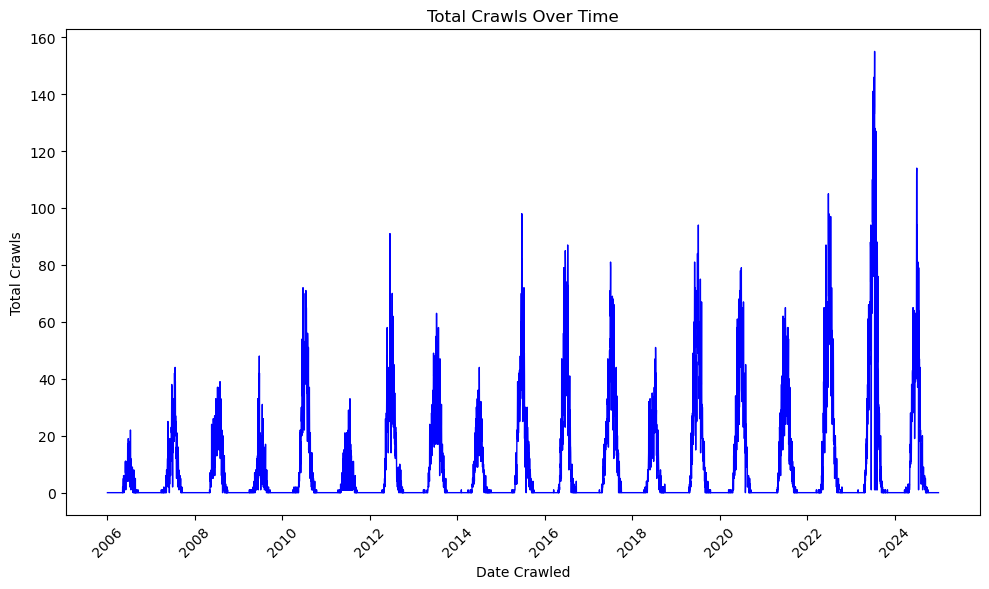

In [63]:
final_df['Date Crawled'] = pd.to_datetime(final_df['Date Crawled'])

# Plotting total crawls over time
plt.figure(figsize=(10, 6))
plt.plot(final_df['Date Crawled'], final_df['total_crawls'], color='b', linestyle='-', linewidth=1, markersize=4)

# Adding labels and title
plt.title('Total Crawls Over Time')
plt.xlabel('Date Crawled')
plt.ylabel('Total Crawls')

# Showing plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This is a pretty interresting plot because we can see that 2022-2024 appear to all have days where over 100 crawls were documented (which is significant). This is the first time we see a pattern appear where three years in a row each had this happen. 2015 and 2012 may have had some 100+ crawl days, however to go from a few years here and three to three consecuitive years of high daily crawls could indicate that the nesting population is increasing or that crawl activity is becoming more synchronized on specific days. However, to get a better idea of the year to year changes, I am going group total crawls by year and plot those values over time.

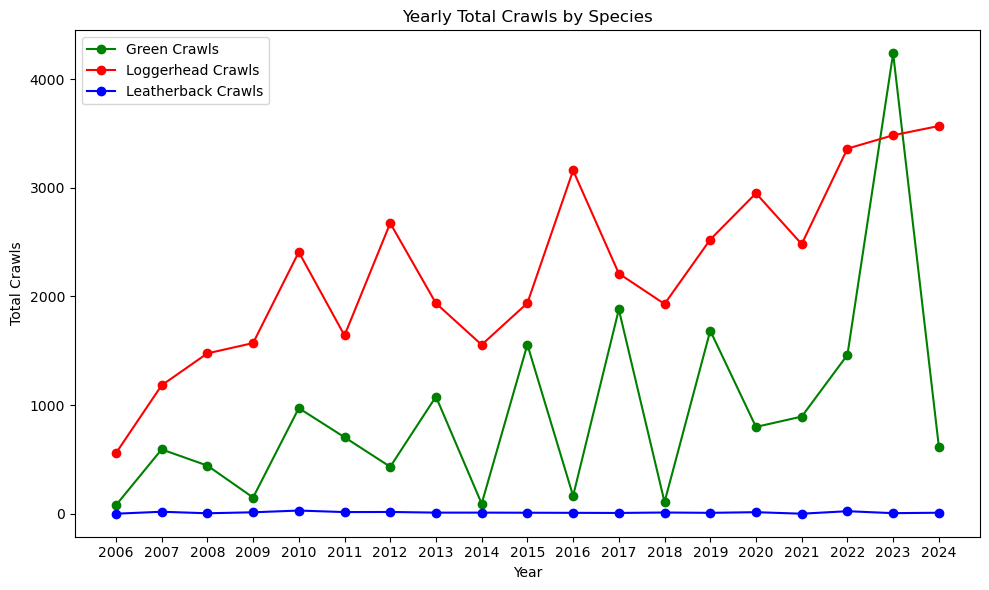

In [64]:
# Extracting the year from the 'Date Crawled' column
final_df['Year'] = final_df['Date Crawled'].dt.year

# Grouping by year and summing the total crawls for each species
yearly_totals = final_df.groupby('Year')[['total_green_crawls', 'total_loggerhead_crawls', 'total_leatherback_crawls']].sum()

# Creating the plot
plt.figure(figsize=(10, 6))

# Plotting for each species
plt.plot(yearly_totals.index, yearly_totals['total_green_crawls'], marker='o', color='g', label='Green Crawls')
plt.plot(yearly_totals.index, yearly_totals['total_loggerhead_crawls'], marker='o', color='r', label='Loggerhead Crawls')
plt.plot(yearly_totals.index, yearly_totals['total_leatherback_crawls'], marker='o', color='b', label='Leatherback Crawls')

# Adding labels and title
plt.title('Yearly Total Crawls by Species')
plt.xlabel('Year')
plt.ylabel('Total Crawls')

# Addding legend to differentiate species
plt.legend()

plt.title('Yearly Total Crawls by Species')
plt.xlabel('Year')
plt.ylabel('Total Crawls')

plt.xticks(yearly_totals.index)

# Showing the plot
plt.tight_layout()
plt.show()

I also broke this graph out by species so that we can see any differences in species patterns as well. Loggerheads are showing a general upward trend, and greens are particularly interesting - from about 2012-2019 they had a very clear up and down pattern, which is not surprising because this species nests fairly predictably every other year. However, that pattern broke abbit from 2020-2022, before shooting way up in 2023. Leatherbacks are rather rdata deficient on this stretch of beach because they are so rare, so it is difficult to discern any real patterns with this species. This indicates that taking species-specific behaviors in account could also be important for modeling. LAst, I am going to plot a similar graph to this, but now breaking out the type of crawls between nesting crawls and non-nestnig crawls.

In [65]:
# Extracting the year from the 'Date Crawled' column
final_df['Year'] = final_df['Date Crawled'].dt.year

# Grouping by year and sum the total nests and false crawls for each species
yearly_totals_by_type = final_df.groupby('Year')[['green_nest', 'green_fc', 'loggerhead_nest', 'loggerhead_fc', 'leatherback_nest', 'leatherback_fc']].sum()

In [66]:
# Checking the yearly groupings
yearly_totals_by_type

,green_nest,green_fc,loggerhead_nest,loggerhead_fc,leatherback_nest,leatherback_fc
Year,,,,,,
2006,31,47,174,383,0,0
2007,332,260,551,631,18,0
2008,257,186,724,752,4,0
2009,85,64,620,951,11,2
2010,246,726,983,1426,26,3
2011,311,393,807,834,15,0
2012,226,206,1384,1291,11,5
2013,569,509,1077,860,8,2
2014,38,54,730,825,9,1


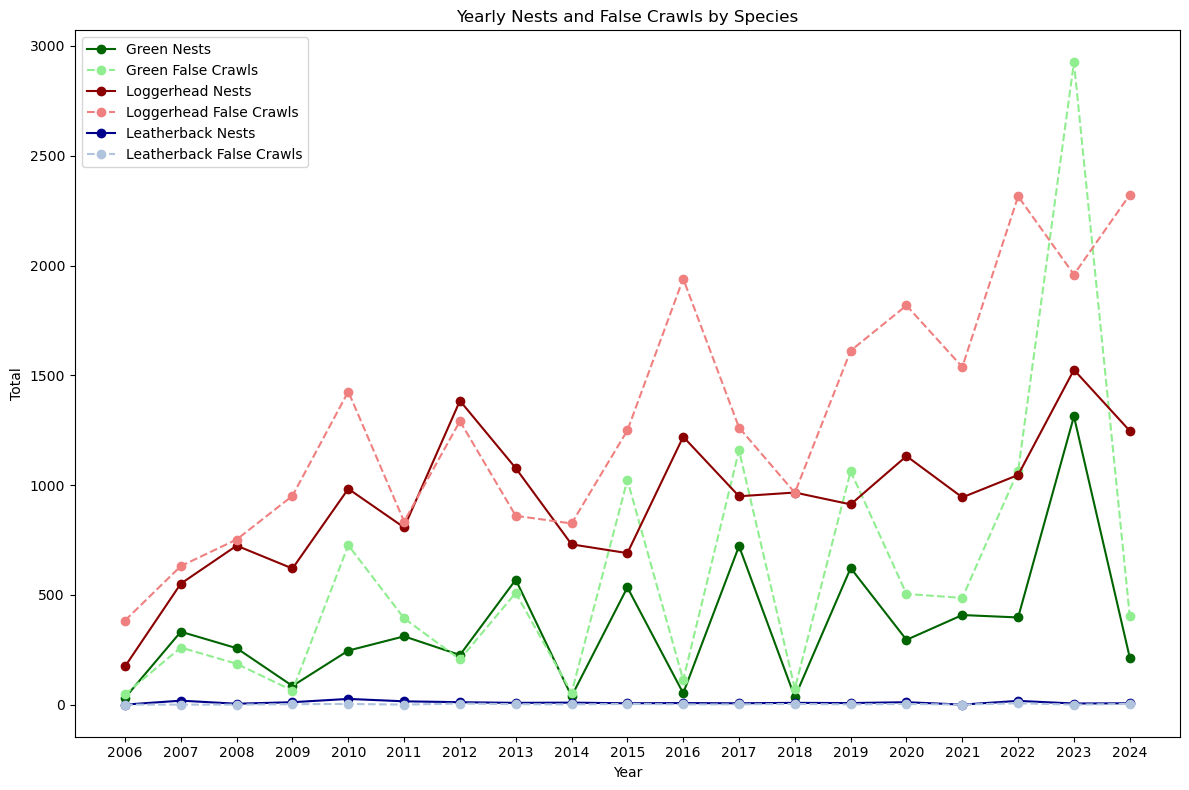

In [67]:
# Creating the plot
plt.figure(figsize=(12, 8))

# Plotting for Green species
plt.plot(yearly_totals_by_type.index, yearly_totals_by_type['green_nest'], marker='o', color='darkgreen', label='Green Nests', linestyle='-')
plt.plot(yearly_totals_by_type.index, yearly_totals_by_type['green_fc'], marker='o', color='lightgreen', label='Green False Crawls', linestyle='--')

# Plotting for Loggerhead species
plt.plot(yearly_totals_by_type.index, yearly_totals_by_type['loggerhead_nest'], marker='o', color='darkred', label='Loggerhead Nests', linestyle='-')
plt.plot(yearly_totals_by_type.index, yearly_totals_by_type['loggerhead_fc'], marker='o', color='lightcoral', label='Loggerhead False Crawls', linestyle='--')

# Plotting for Leatherback species
plt.plot(yearly_totals_by_type.index, yearly_totals_by_type['leatherback_nest'], marker='o', color='darkblue', label='Leatherback Nests', linestyle='-')
plt.plot(yearly_totals_by_type.index, yearly_totals_by_type['leatherback_fc'], marker='o', color='lightsteelblue', label='Leatherback False Crawls', linestyle='--')

# Adding labels and title
plt.title('Yearly Nests and False Crawls by Species')
plt.xlabel('Year')
plt.ylabel('Total')

# Adding legend to differentiate species and types
plt.legend()

# Setting x-axis ticks to integer years
plt.xticks(yearly_totals_by_type.index)

# Showing plot
plt.tight_layout()
plt.show()

This is also an interesting graph because we can see how each species varies with nesting and non-nesting crawls in each season. While one turtle can false crawl multiple times in a night, she can only nest once every couple of weeks. Greens especially tend to be more sensitive to disturbances and false crawl more frequently, so it is interesting to see a significant increase in false crawls vs nests in years of high green turtle nesting. 

### Correlation Matrix

Next, I am going to make a correlation matrix to see if any relationships between crawls and different environmental variables emerge. 

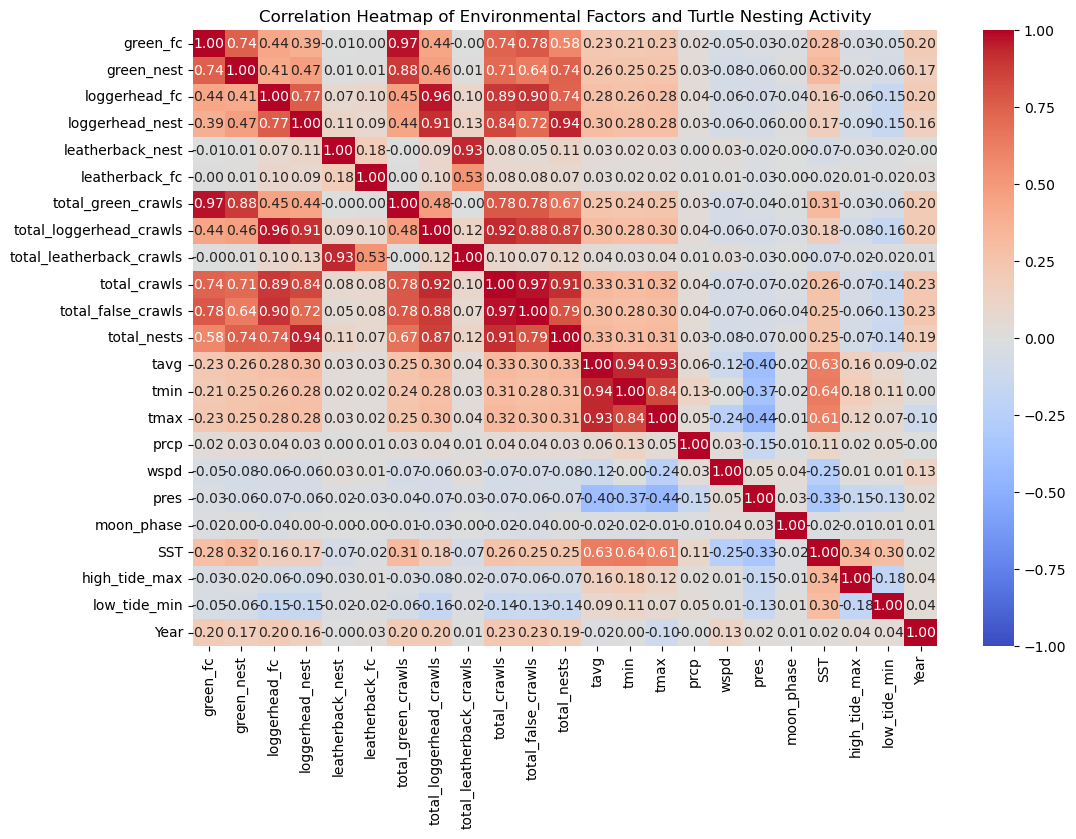

In [68]:
numeric_df = final_df.select_dtypes(include=np.number)

# Calculating correlations
corr_matrix = numeric_df.corr()

# Creating heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Environmental Factors and Turtle Nesting Activity")
plt.show()

From a quick glance, not obvious relationships emerge, though there does seem to be a moderate positive relationship between greent turtle nesting activity and sea surface temperature. There are also some relationships between green and loggerhead crawls and ambient temperature, though this could also be attributed to the seasonal pattern that sea turtle nesting follows and less of a relationship with temperature specifically. 

### Scatter Plots

Next, I am going to make a series of scatterplots exploring some relationships between crawl activity and different environmental variables. The first four will look at loggerhead and green nesting crawls and average ambient temperature and sea surface temperature. The next plots will look at moon phase, high and low tide heights, and rainfall vs total crawls.

#### Temperature vs Nesting Activity

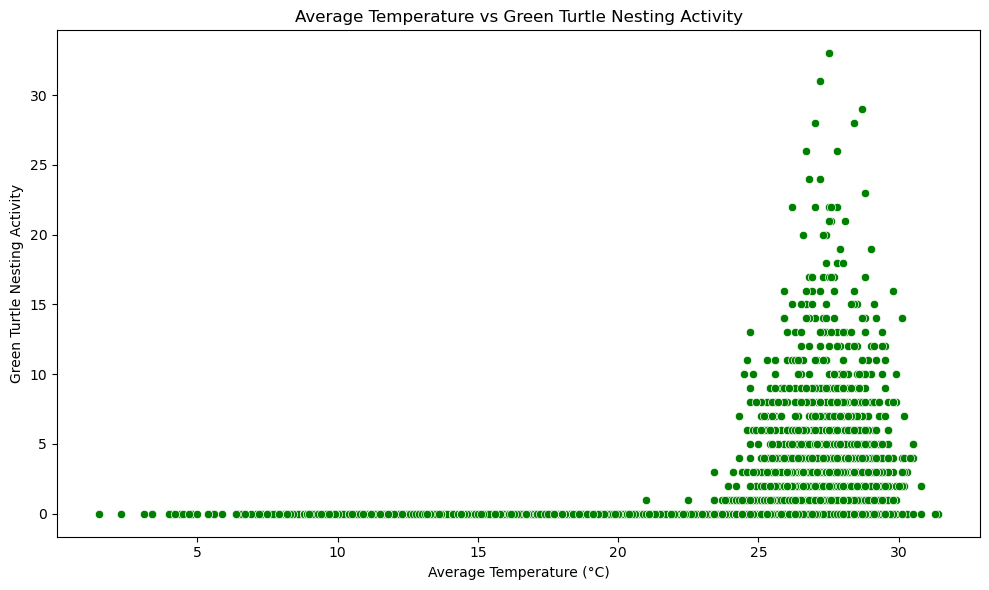

In [69]:
# Plotting average temp vs. Green turtle nesting activity 
plt.figure(figsize=(10, 6))
sns.scatterplot(x=final_df['tavg'], y=final_df['green_nest'], color='green')
plt.title('Average Temperature vs Green Turtle Nesting Activity')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Green Turtle Nesting Activity')
plt.tight_layout()
plt.show()

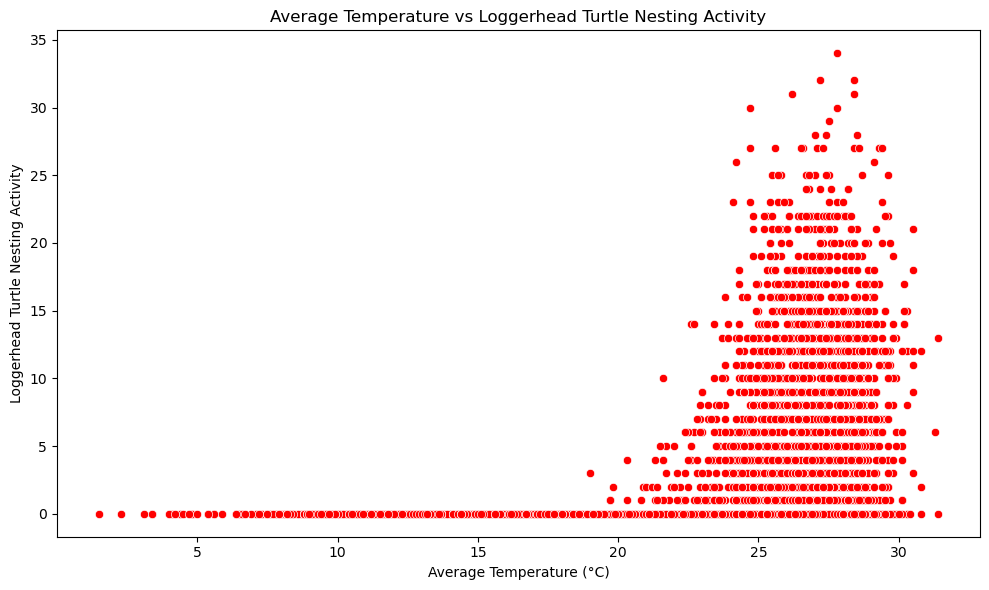

In [70]:
# Plotting average temperature vs loggerhead nesting crawls
plt.figure(figsize=(10, 6))
sns.scatterplot(x=final_df['tavg'], y=final_df['loggerhead_nest'], color='red')
plt.title('Average Temperature vs Loggerhead Turtle Nesting Activity')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Loggerhead Turtle Nesting Activity')
plt.tight_layout()
plt.show()

#### Sea Surface Temperature vs. Nesting Activity

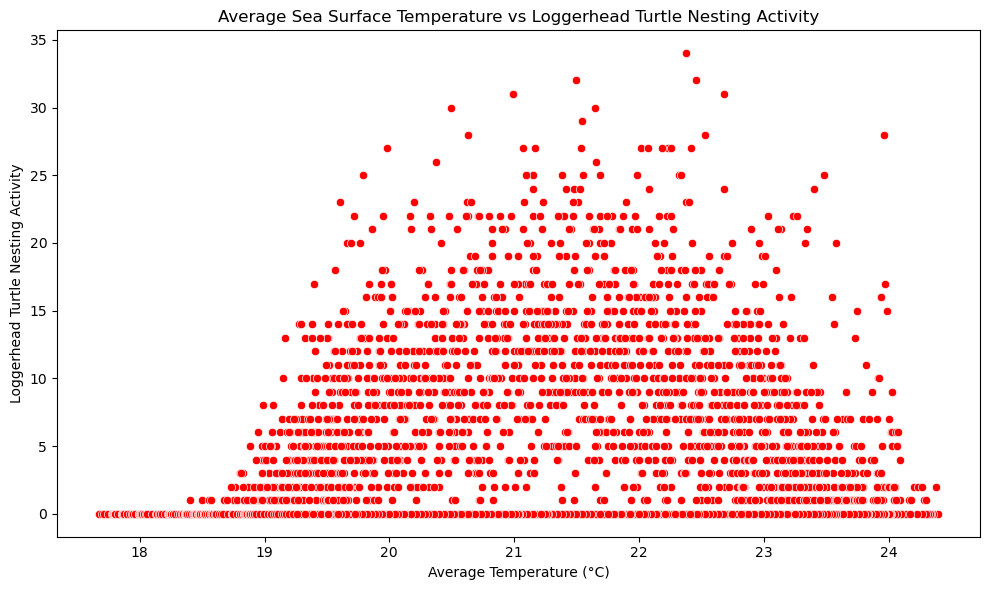

In [71]:
# Plotting sea surface temperature vs loggerhead nesting crawls
plt.figure(figsize=(10, 6))
sns.scatterplot(x=final_df['SST'], y=final_df['loggerhead_nest'], color='red')
plt.title('Average Sea Surface Temperature vs Loggerhead Turtle Nesting Activity')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Loggerhead Turtle Nesting Activity')
plt.tight_layout()
plt.show()

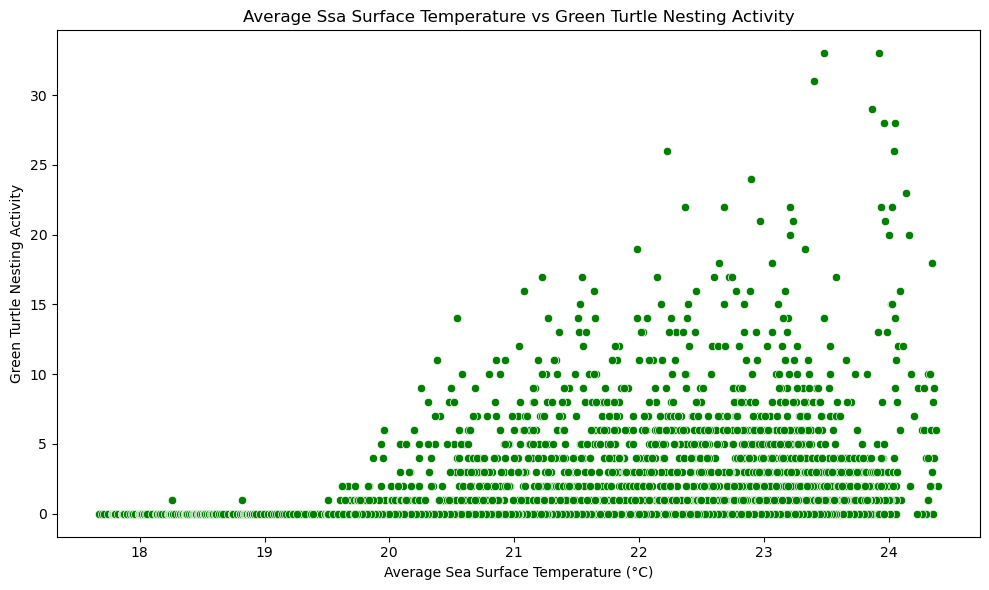

In [72]:
# Plotting sea surface temperature vs green sea turtle nesting crawls
plt.figure(figsize=(10, 6))
sns.scatterplot(x=final_df['SST'], y=final_df['green_nest'], color='green')
plt.title('Average Surface Temperature vs Green Turtle Nesting Activity')
plt.xlabel('Average Sea Surface Temperature (°C)')
plt.ylabel('Green Turtle Nesting Activity')
plt.tight_layout()
plt.show()

#### Moon Phase vs Crawls

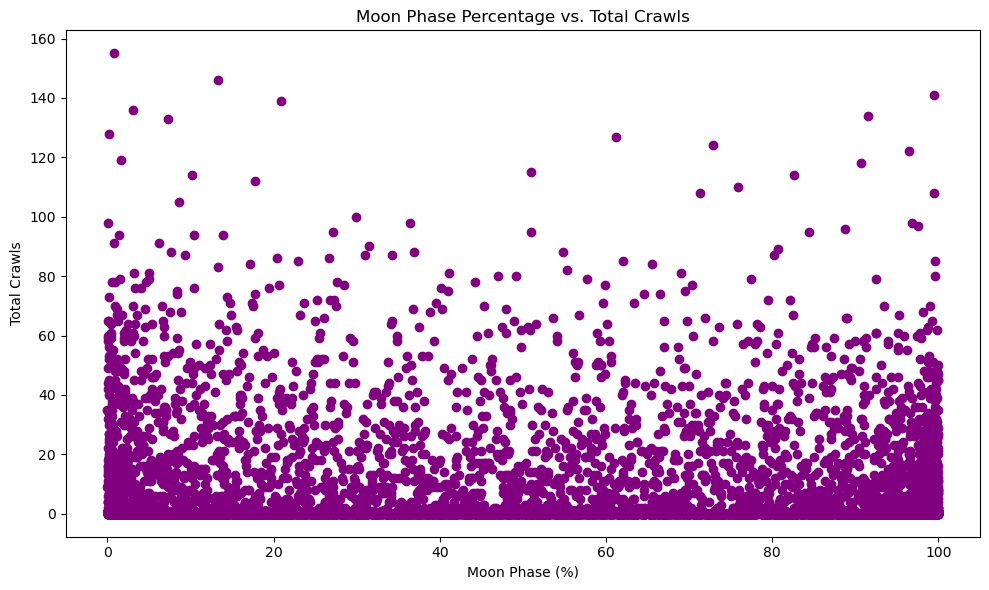

In [73]:
# Plotting moon phase vs total crawls
plt.figure(figsize=(10, 6))
plt.scatter(final_df['moon_phase'], final_df['total_crawls'], color='purple')
plt.title('Moon Phase Percentage vs. Total Crawls')
plt.xlabel('Moon Phase (%)')
plt.ylabel('Total Crawls')
plt.tight_layout()
plt.show()

#### Tides vs. Total Crawls

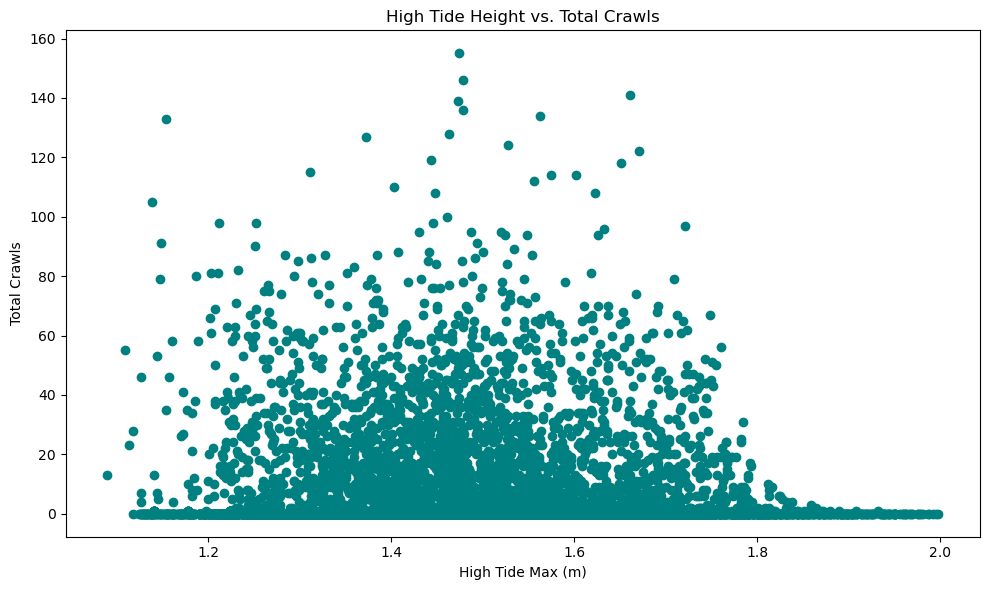

In [74]:
# Plotting max high tide height vs total crawls
plt.figure(figsize=(10, 6))
plt.scatter(final_df['high_tide_max'], final_df['total_crawls'], color='teal')
plt.title('High Tide Height vs. Total Crawls')
plt.xlabel('High Tide Max (m)')
plt.ylabel('Total Crawls')
plt.tight_layout()
plt.show()

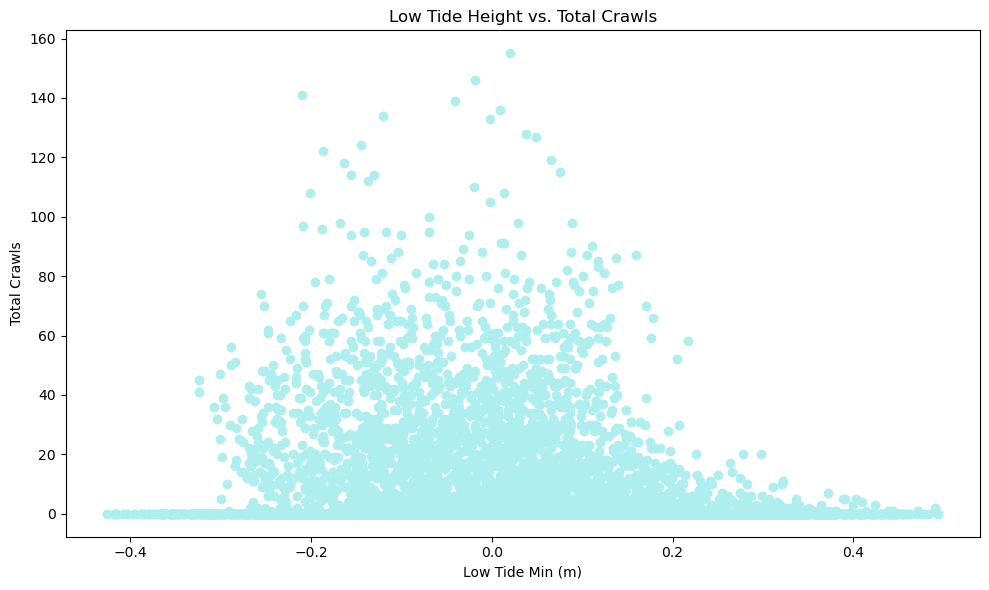

In [75]:
# PLotting min low tide height vs total crawls
plt.figure(figsize=(10, 6))
plt.scatter(final_df['low_tide_min'], final_df['total_crawls'], color='paleturquoise')
plt.title('Low Tide Height vs. Total Crawls')
plt.xlabel('Low Tide Min (m)')
plt.ylabel('Total Crawls')
plt.tight_layout()
plt.show()

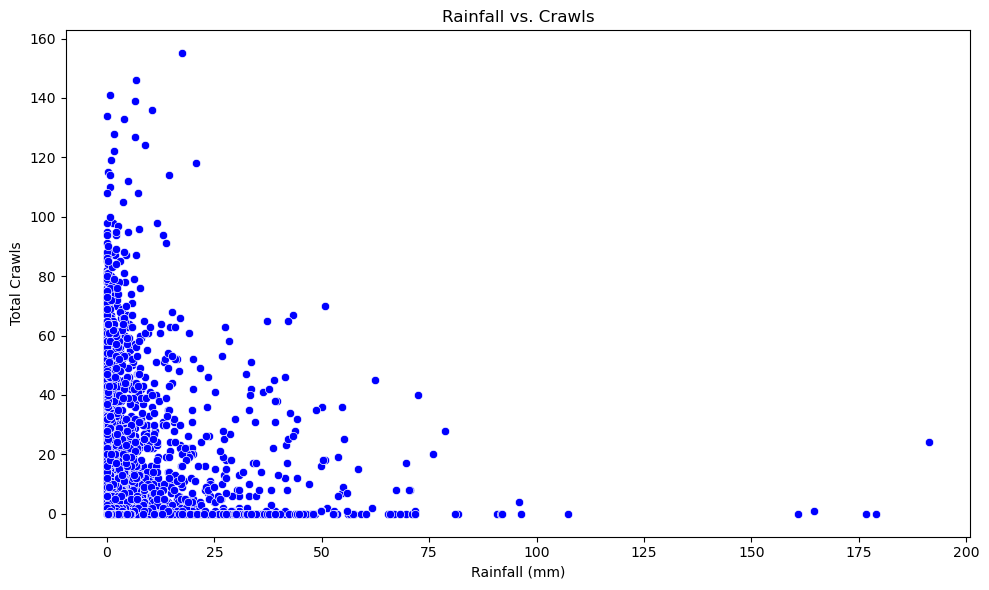

In [76]:
# PLotting rainfall vs total crawls
plt.figure(figsize=(10, 6))
sns.scatterplot(x='prcp', y='total_crawls', data=final_df, color='blue')
plt.title('Rainfall vs. Crawls')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Total Crawls')
plt.tight_layout()
plt.show()

Overall, not too many interesting takeaways from these scatterplots. Green sea turtles seem to nest more when sea surface temperature is higher as opposed to loggerheads. No significant relationships exist really exist with rainfall or moon phase, and tides also don't appear to have much significance based on visualizations alone. However, modeling may bring out some of the nuances in relationships that we can't see, so we will now move onto feature selection.

### Automating Feature Selection

The primary model that will be used to predict sea turtle nesting activity will be a SARIMAX model. Because of the seasonal nature of sea turtle nesting behavior, along with the desire to see how environmental variables may influence nesting behavior, a SARIMAX is well suited for this data because of the seasonality and ability to incorporate exogenous variables. However, EDA did not produce many insights into potential relationhsips, so a different method of feature selection will have to be conducted to choose the best exogenous variables to incorporate into the SARIMAX model. 

To assess the relationship between environmental factors and sea turtle nesting activity, a Random Forest model will first implemented as an exploratory step to determine the relative importance of different predictor variables. This approach allows for a non-parametric assessment of potential feature significance without making strong assumptions about the underlying data structure.

In [77]:
# Checking weekly data frame
weekly_df.head()

,Date Crawled_,green_fc_sum,green_nest_sum,loggerhead_fc_sum,loggerhead_nest_sum,leatherback_nest_sum,leatherback_fc_sum,total_green_crawls_sum,total_loggerhead_crawls_sum,total_leatherback_crawls_sum,total_crawls_sum,total_false_crawls_sum,total_nests_sum,tavg_mean,tmin_avg,tmin_min,tmax_avg,tmax_max,prcp_mean,wspd_mean,pres_mean,SST_mean,high_tide_avg,high_tide_max,low_tide_avg,low_tide_min,moon_phase_avg
0,2006-01-01,0,0,0,0,0,0,0,0,0,0,0,0,19.500000,10.900000,10.9,27.500000,27.5,0.000000,8.300000,1018.500000,19.215424,1.657000,1.657,-0.248000,-0.248,1.269116
1,2006-01-08,0,0,0,0,0,0,0,0,0,0,0,0,15.528571,8.257143,-0.8,22.342857,28.6,0.000000,13.057143,1017.928571,19.069969,1.463000,1.641,-0.135714,-0.247,32.069432
2,2006-01-15,0,0,0,0,0,0,0,0,0,0,0,0,17.085714,9.814286,3.6,23.485714,27.0,0.257143,13.328571,1019.728571,18.869415,1.404571,1.422,-0.070714,-0.082,90.713306
3,2006-01-22,0,0,0,0,0,0,0,0,0,0,0,0,17.971429,13.071429,3.6,24.985714,27.5,0.914286,16.042857,1022.428571,18.635505,1.224571,1.362,0.041571,-0.057,79.875142
4,2006-01-29,0,0,0,0,0,0,0,0,0,0,0,0,18.271429,14.814286,8.1,24.357143,28.6,0.042857,16.985714,1023.728571,18.500482,1.369143,1.607,-0.102714,-0.318,20.206531


In [78]:
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [79]:
# Defining features and targets
features = ['tavg_mean','tmin_avg','tmin_min','tmax_avg','tmax_max','prcp_mean','wspd_mean','pres_mean',
            'SST_mean','high_tide_avg','high_tide_max','low_tide_avg','low_tide_min','moon_phase_avg']
target = 'total_crawls_sum'

In [80]:
# Defining X and y variables
X = weekly_df[features]
y = weekly_df[target]

In [81]:
# Scaling the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

#### Random Forest Total Crawls

In [83]:
# Splitting into 80% training and 20% test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((794, 14), (199, 14), (794,), (199,))

In [84]:
# Instantiating the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Training the model
rf_model.fit(X_train, y_train)

# Predicting on test data
y_pred = rf_model.predict(X_test)

In [85]:
# Evaluating with MSE and RMSE
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 6121.699172864322
R-squared: 0.6620144783334128


In [86]:
# Performing a Randomized Search CV to optimize hyperparameters
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                               param_distributions=param_dist,
                               n_iter=50,  # Number of random samples to test
                               cv=3, n_jobs=-1, verbose=2)

rf_random.fit(X_train, y_train)

# Retrieving the best parameters found
print("Best parameters:", rf_random.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 892}


In [87]:
# Evaluating best model hyperparameters on test set
y_pred_random = rf_random.predict(X_test)
mse_random = mean_squared_error(y_test, y_pred_random)
r2_random = r2_score(y_test, y_pred_random)

print(f'RandomizedSearch MSE: {mse_random}')
print(f'RandomizedSearch R-squared: {r2_random}')

RandomizedSearch MSE: 6749.750790530172
RandomizedSearch R-squared: 0.6273390805988628


The hyperparameters identified in the random search actually performed worse than the original model, so I will extract the feature importances using the original model.

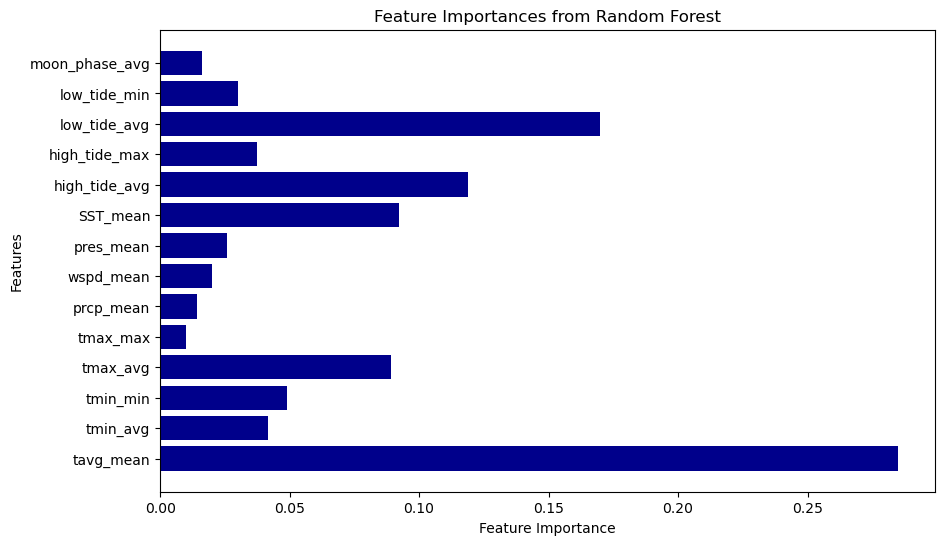

In [88]:
# Retrieving feature importances using the best model (original model)
feature_importances = rf_model.feature_importances_

features = X.columns

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances, color='darkblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances from Random Forest")
plt.show()

The Random Forest model provided some insightful results, with a Mean Squared Error (MSE) of 6121.70 and an R-squared value of 0.66. These metrics suggest that the model explained approximately 66% of the variance in sea turtle nesting activity, indicating a moderate fit. While a Randomized Search Cross-Validation (CV) was performed to fine-tune the model’s parameters, the optimal parameters identified during this process actually led to worse performance than the initial model. Despite this, the analysis of feature importance highlighted several key environmental factors influencing nesting behavior, including sea surface temperature, average high tide height, average low tide height, and average ambient temperature (Figure 3). These features emerged as the most influential in predicting sea turtle nesting activity, suggesting their potential importance to influencing nesting behavior and allowed a narrower focus for features moving into SARIMA and SARIMAX modeling.

### Pre-Model Testing

To select the parameters for the SARIMA and SARIMAX models, spectral density analysis and ACF/PACF plots will be used. Spectral density will help identify dominant seasonal cycles, while ACF and PACF plots will guide the selection of the autoregressive (AR) and moving average (MA) orders, as well as the seasonal components. Additionally, an Augmented Dickey-Fuller (ADF) test will be conducted to assess stationarity, as SARIMA and SARIMAX models assume a stationary time series. If the data exhibit trends or seasonality, differencing will be applied as needed. To further understand the underlying structure of the time series, seasonal decomposition will be performed, breaking the data into trend, seasonal, and residual components to visualize patterns that may influence model selection.

In [111]:
from statsmodels.tsa.stattools import adfuller

In [112]:
# Selecting the time series variable for stationarity test
time_series = weekly_df["total_crawls_sum"]

# Performing the Augmented Dickey-Fuller test
adf_test = adfuller(time_series)

# Extracting results
adf_statistic, p_value, _, _, critical_values, _ = adf_test

# Displaying results
{
    "ADF Statistic": adf_statistic,
    "p-value": p_value,
    "Critical Values": critical_values,
}

{'ADF Statistic': -8.477978137488256,
 'p-value': 1.418290355788127e-13,
 'Critical Values': {'1%': -3.43706091543889,
  '5%': -2.8645028204932483,
  '10%': -2.568347558984588}}

In [113]:
from statsmodels.tsa.seasonal import seasonal_decompose

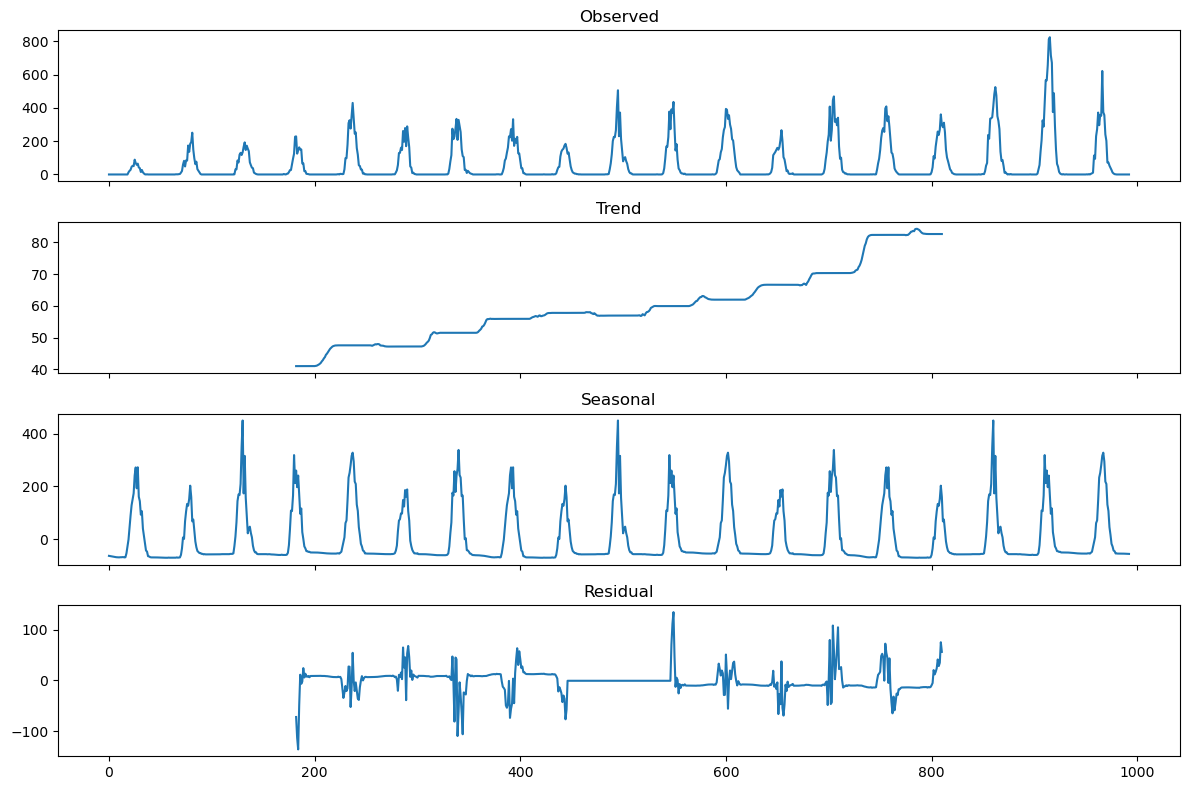

In [114]:
# Performing seasonal decomposition
decomposition = seasonal_decompose(weekly_df["total_crawls_sum"], model="additive", period=365)

# Plotting decomposition results
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
decomposition.observed.plot(ax=axes[0], title="Observed")
decomposition.trend.plot(ax=axes[1], title="Trend")
decomposition.seasonal.plot(ax=axes[2], title="Seasonal")
decomposition.resid.plot(ax=axes[3], title="Residual")

plt.tight_layout()
plt.show()

In [115]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import aic, bic
import itertools
import statsmodels.api as sm
from scipy.signal import periodogram

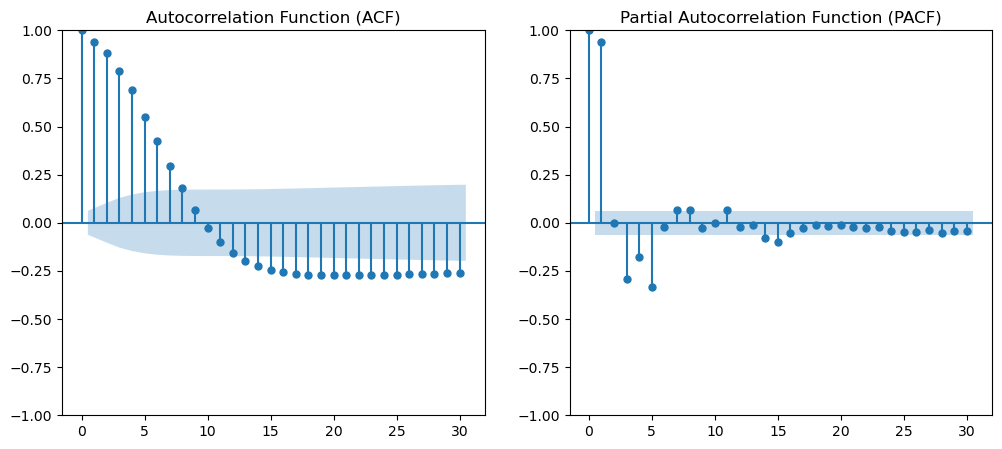

In [116]:
# PLotting ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(weekly_df['total_crawls_sum'].dropna(), ax=axes[0])
plot_pacf(weekly_df['total_crawls_sum'].dropna(), ax=axes[1])
axes[0].set_title("Autocorrelation Function (ACF)")
axes[1].set_title("Partial Autocorrelation Function (PACF)")
plt.show()

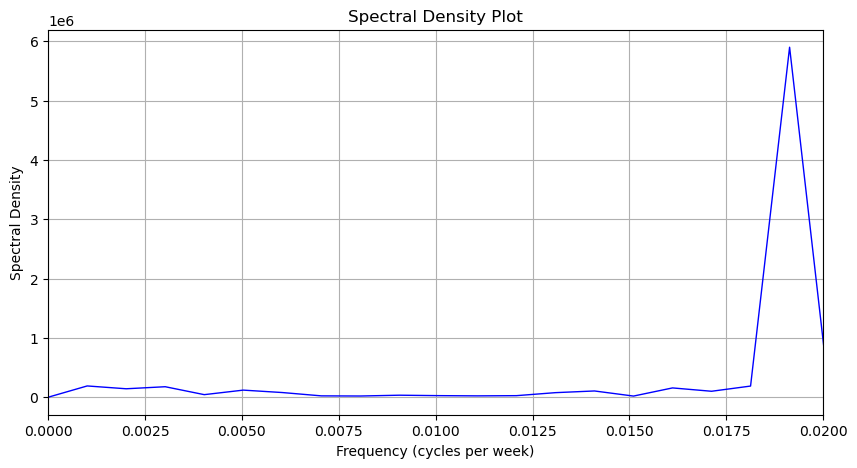

In [117]:
weekly_df = weekly_df.sort_index()

# Extracting the time series (assuming 'total_crawls' is the target variable)
ts = weekly_df['total_crawls_sum'].dropna()

# Computing the periodogram (spectral density plot)
freqs, power = periodogram(ts, scaling='density')

# Plotting the spectral density
plt.figure(figsize=(10, 5))
plt.plot(freqs, power, color='blue', lw=1)
plt.xlim(0, 0.02)  # Focus on lower frequencies to identify seasonal cycles
plt.xlabel('Frequency (cycles per week)')
plt.ylabel('Spectral Density')
plt.title('Spectral Density Plot')
plt.grid()
plt.show()

Based on the results of these analyses, a SARIMA(2, 0, 0)x(0, 1, [1], 52) will be used for this analysis, and these parameters were chosen as follows:

**(2, 0, 0) (Non-seasonal component):**

- **p = 2:** The PACF plot showed a sharp cutoff at lag 2, indicating two significant autoregressive terms.
- **d = 0:** The ADF showed stationarity (very low p-value), so no differencing is needed.
- **q = 0:** The ACF plot did not show a strong cutoff, indicating no moving average terms were necessary.

**(0, 1, [1], 52) (Seasonal component with a 52-week cycle):**

- **P = 0:**  No significant seasonal autoregressive terms were found.
- **D = 1:** Decomposition and spectral density indicated that seasonal difference was required.
- **Q = 1:** ACF suggests a significant annual seasonal moving average term.
- **s = 52:** Spectral density analysis confirmed a strong annual (52-week) seasonality in the data.

### Modeling

As stated before, given the temporal nature of sea turtle nesting patterns, a SARIMA (Seasonal Autoregressive Integrated Moving Average) model will be the primary model used in this analysis looking to predict sea turtle nesting activity. First, a SARIMA will be fit to the data and used as a baseline to capture seasonality and temporal dependencies. The model will then be expanded to a SARIMAX (SARIMA with Exogenous Variables) model by incorporating environmental factors, such as tide height, ambient temperature, and sea surface temperature, as external regressors to assess their influence on nesting activity. 

#### Baseline SARIMA Models

In [118]:
# Setting up the SARIMA model with chosen parameters
sarima_model_crawls = SARIMAX(weekly_df['total_crawls_sum'], 
                       order=(2, 0, 0), 
                       seasonal_order=(0, 1, 1, 52), 
                       enforce_stationarity=False, 
                       enforce_invertibility=False)

In [119]:
# Fitting the base SARIMA model
sarima_results_crawls = sarima_model_crawls.fit(disp=False)

In [120]:
# Printing baseline SARIMA model results
print(sarima_results_crawls.summary())

                                      SARIMAX Results                                       
Dep. Variable:                     total_crawls_sum   No. Observations:                  993
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 52)   Log Likelihood               -4448.271
Date:                              Sun, 23 Feb 2025   AIC                           8904.541
Time:                                      21:09:05   BIC                           8923.697
Sample:                                           0   HQIC                          8911.864
                                              - 993                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5513      0.013     40.898      0.000       0.525       0.578
ar.L2          0.30

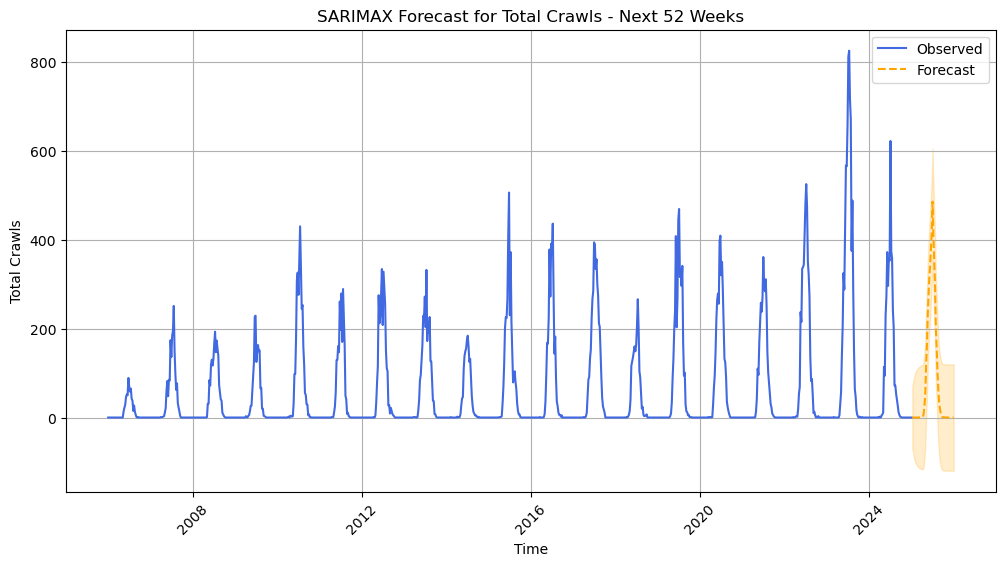

In [122]:
weekly_df = weekly_df.set_index("Date Crawled_")
weekly_df.index = pd.to_datetime(weekly_df.index)

# Forecasting the next 52 weeks
forecast_steps = 52
forecast = sarima_results_crawls.get_forecast(steps=forecast_steps)

# Extracting forecasted values and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Generating the time index for the forecast, ensuring continuity from the last date in the dataset
last_date = weekly_df.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=forecast_steps, freq='W')

# Plotting the forecast
plt.figure(figsize=(12, 6))
plt.plot(weekly_df.index, weekly_df['total_crawls_sum'], label="Observed", color='royalblue')
plt.plot(forecast_index, forecast_mean, label="Forecast", color='orange', linestyle='--')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='orange', alpha=0.2)

# Formatting the x-axis
plt.xticks(rotation=45)
plt.title("SARIMAX Forecast for Total Crawls - Next 52 Weeks")
plt.xlabel("Time")
plt.ylabel("Total Crawls")
plt.legend()
plt.grid(True)
plt.show()

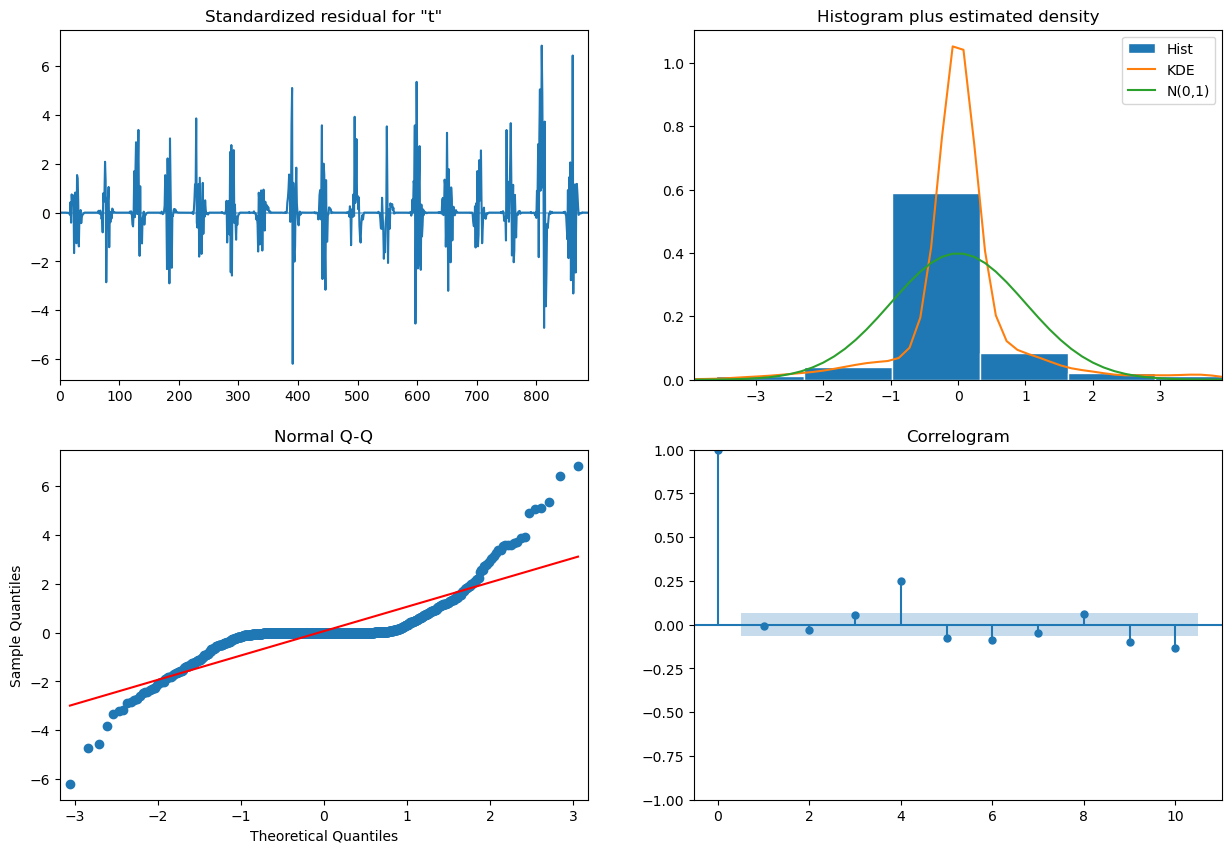

In [123]:
# Plotting diagnostics for the results of the model
sarima_results_crawls.plot_diagnostics(figsize=(15, 10))
plt.show()

Results from the baseline SARIMA model showed significant autoregressive (AR) components at lags 1 and 2, indicating a strong temporal relationship between past and current nesting activity. The seasonal moving average (MA) component highlighted the importance of seasonal fluctuations, specifically related to yearly cycles. Diagnostic tests, such as the Ljung-Box test, showed that residual autocorrelation was minimal, suggesting that the model had adequately captured the temporal structure of the data (p=0.78). However, the residuals did display some skewness and kurtosis, which was indicative of non-normality, but did not undermine the overall fit of the model.

#### Adding Exogenous Variables

Now that the baseline SARIMA has been fit, it is time to add in the exogenous variables. Average ambient temperature, sea surface temperature, and high and low tide averages were indicated to be some of the most influential variables in the Random Forest model. 

In [124]:
# Defining the exogenous variables
exog_vars = weekly_df[['tavg_mean', 'SST_mean', 'low_tide_avg', 'high_tide_avg']]

In [125]:
# Setting up the SARIMAX model
sarimax_exog_model = SARIMAX(weekly_df['total_crawls_sum'],
                             order=(2, 0, 0), 
                             seasonal_order=(0, 1, 1, 52), 
                             exog=exog_vars,  # Exogenous variables
                             enforce_stationarity=False, 
                             enforce_invertibility=False)

# Fitting the model
sarimax_exog_results = sarimax_exog_model.fit(disp=False)

# Printing the summary
print(sarimax_exog_results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                     total_crawls_sum   No. Observations:                  993
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 52)   Log Likelihood               -4445.477
Date:                              Sun, 23 Feb 2025   AIC                           8906.953
Time:                                      21:12:58   BIC                           8945.265
Sample:                                  01-01-2006   HQIC                          8921.598
                                       - 01-05-2025                                         
Covariance Type:                                opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
tavg_mean         0.7067      1.488      0.475      0.635      -2.209       3.623
SST_mean  

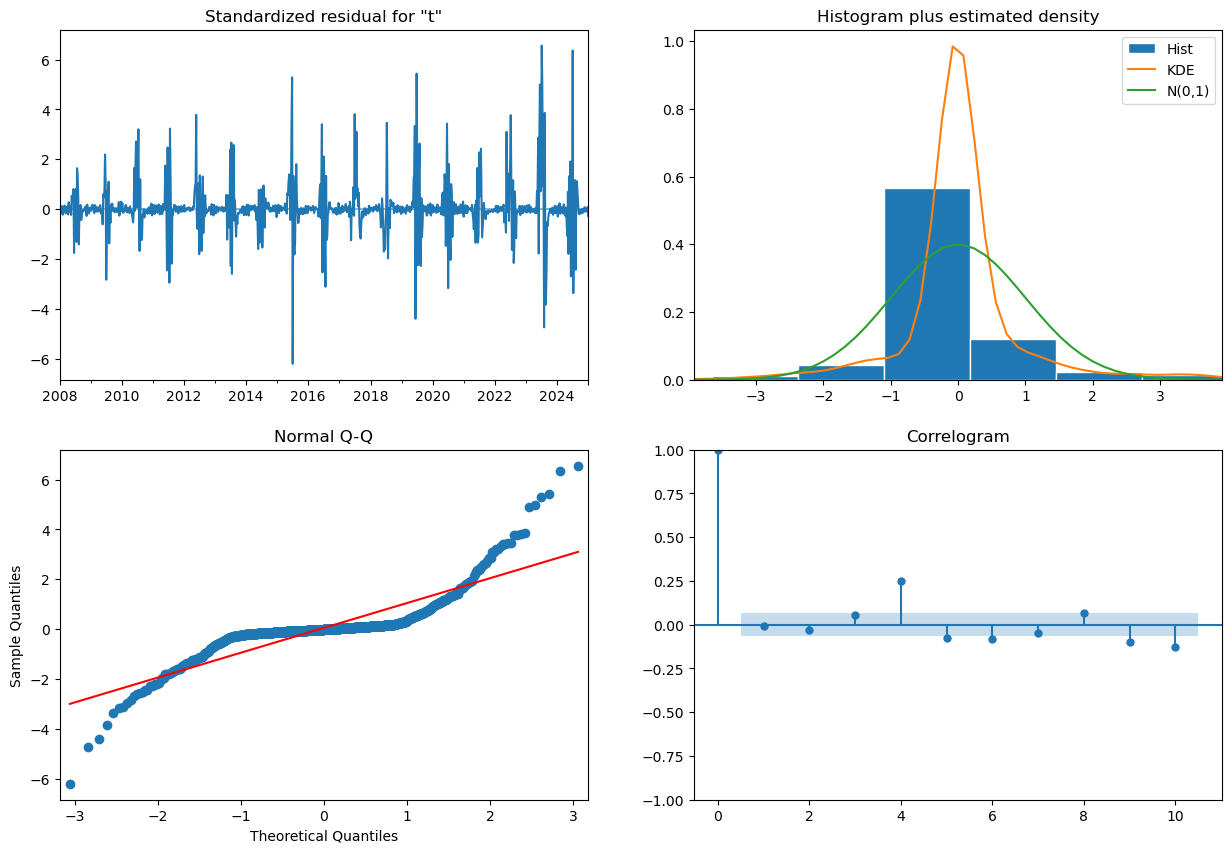

In [127]:
# Plotting diagnostics for the results of the model
sarimax_exog_results.plot_diagnostics(figsize=(15, 10))
plt.show()

The SARIMAX model revealed that high tide and low tide heights were statistically significant predictors, with high tide height having a notably positive influence on nesting activity (coef = 67.1994, p = 0.005) and low tide height also contributing significantly (coef = 52.4180, p = 0.044). However, environmental variables such as temperature and sea surface temperature did not show significant relationships with nesting activity (p-values above 0.05). The temporal structure was well-captured by the autoregressive and seasonal moving average components, as indicated by the significant coefficients for the AR(1) and AR(2) lags and the seasonal MA component. Despite capturing these patterns, the model's residuals still exhibited some non-normality, as evidenced by the high kurtosis and skewness.

#### Fitting a Tides-Only SARIMAX Model

Because the temperature variables did noot appear to have a significant influence on the previous SARIMAX model, I am going to rerun the model with only the tide variables as exogenous variables and see if the model improves at all.

In [128]:
# Defining the exg variables
exog_vars_simp = weekly_df[['low_tide_avg', 'high_tide_avg']]

In [129]:
# Setting up the SARIMAX
sarimax_exog_model_simp = SARIMAX(weekly_df['total_crawls_sum'],
                             order=(2, 0, 0), 
                             seasonal_order=(0, 1, 1, 52), 
                             exog=exog_vars_simp,  # Exogenous variables
                             enforce_stationarity=False, 
                             enforce_invertibility=False)

# Fitting the model
sarimax_exog_results_simp = sarimax_exog_model_simp.fit(disp=False)

# Printing the summary
print(sarimax_exog_results_simp.summary())

                                      SARIMAX Results                                       
Dep. Variable:                     total_crawls_sum   No. Observations:                  993
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 52)   Log Likelihood               -4444.094
Date:                              Sun, 23 Feb 2025   AIC                           8900.189
Time:                                      21:15:23   BIC                           8928.922
Sample:                                  01-01-2006   HQIC                          8911.172
                                       - 01-05-2025                                         
Covariance Type:                                opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
low_tide_avg     66.4195     25.854      2.569      0.010      15.747     117.092
high_tide_

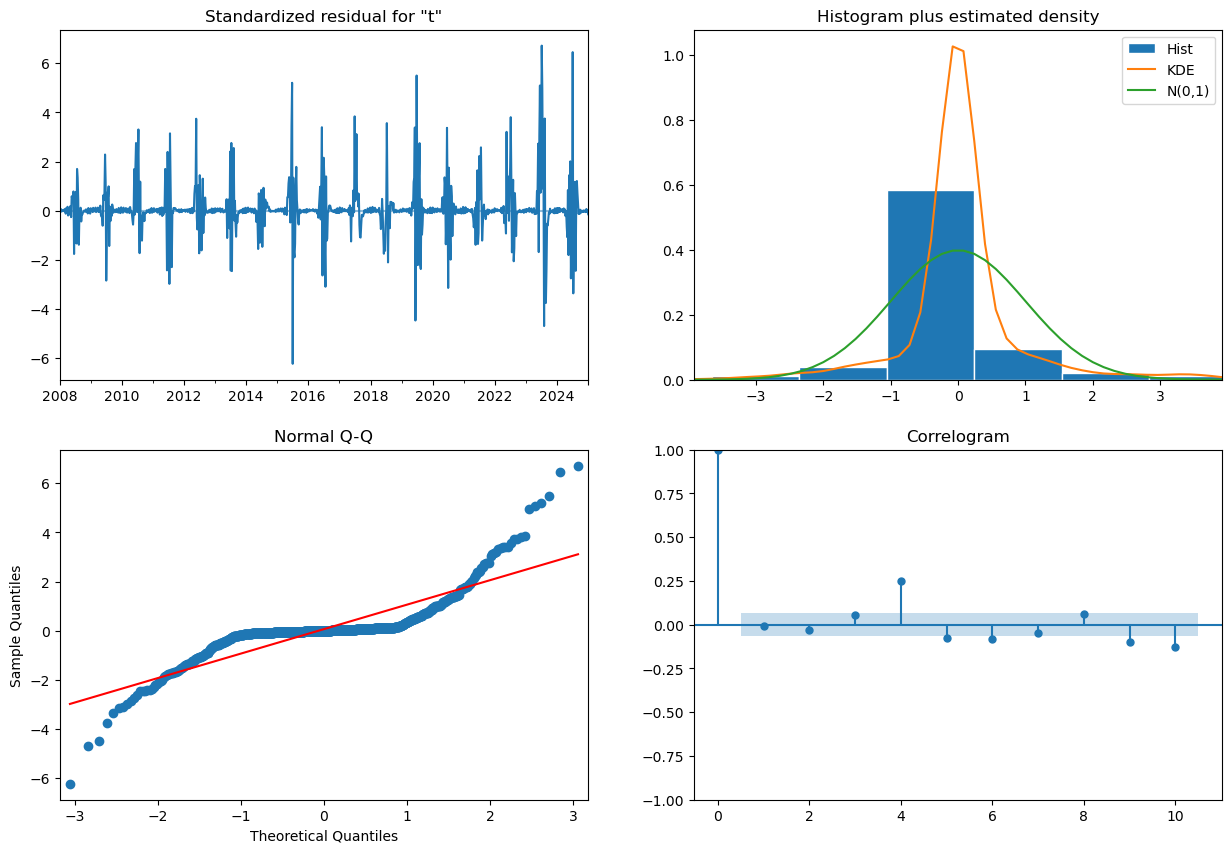

In [130]:
# Plotting diagnostics for the results of the model
sarimax_exog_results_simp.plot_diagnostics(figsize=(15, 10))
plt.show()

This version of the model, which included just the average high and low tide heights, showed a slight improvement in the Akaike Information Criterion (AIC), reducing it from 8906.953 in the previous model to 8900.189. The tide variables remained statistically significant, with high tide (coef = 68.1278, p = 0.004) and low tide (coef = 66.4195, p =  0.010) continuing to show positive associations with nesting activity. These findings suggest that tide height is a more influential factor in predicting sea turtle activity than other environmental variables. However, similar to the previous models, the residual diagnostics showed some non-normality, but the model still effectively captured the temporal patterns and seasonal fluctuations in the data.

## Conclusions

This study has successfully developed predictive models for sea turtle nesting activity in Indian River County, FL, with a focus on leveraging time series methods and environmental data. Perhaps the biggest finding of this investigation was the potential influences that tidal patterns may have on sea turtle nesting behavior, suggesting that overall higher tides might be associated with increased nesting activity. However, while these findings provide valuable insights, the complex nature of nesting behavior indicates that more investigation is needed to fully understand the relationships at play. Environmental factors beyond tides, such as temperature and sea surface temperature, did not show significant effects in this analysis, but future work should explore potential interactions between multiple environmental variables.

The predictive models developed in this study can be applied to future nesting seasons to better forecast sea turtle nesting activity. By incorporating environmental forecasts into the SARIMAX model, such as predicted tide heights and other relevant conditions, the model can more accurately predict nesting trends throughout the season. These predictions can support conservation efforts by helping anticipate nesting patterns, optimizing resource allocation, and enhancing protection measures. For example, when doing nighttime tagging research this season, we might want to target dates with anticipated higher overall tides to increase our chances of getting an adequate sample size of nesting sea turtles. Furthermore, as more data becomes available, the model can be refined to improve its accuracy and provide deeper insights into the broader environmental factors influencing sea turtle nesting behavior.